## Formatting the data
The data available is not perfect. Some articles have missing information. Such texts will be filtered out - The data will be loaded from a JSON and converted to a Pandas dataframe. 

The necessary features are: __Domain, Body, Header__ and __Byline__. URI is nice to have, but not necessary.

Author: lkt259@alumni.ku.dk

In [4]:
import numpy as np
import pandas as pd
import os, re
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
import random
from difflib import SequenceMatcher
plt.style.use('seaborn')

scrape = True

In [5]:
#Load data - and show 120 characters of the body.
data = pd.read_json(r'data/data_0.json')
pd.set_option('display.max_colwidth', 220)
data.head(3)

,Id,Domain,Body,Header,PublicationDate,Uri,Byline,TextHash
0,842325,politiken.dk,Læs artiklen senere Gemt (klik for at fjerne) Læst Giv artiklen videre Som abonnent kan du ubegrænset dele artikler med dine venner og familie. Læs mere om fordelene ved et abonnement her . FOR ABONNENTER »Der var ov...,Utilfreds passager: »Prøv selv en tur klokken 7.30 en hverdagsmorgen« - politiken.dk,2002-09-17T00:00:00,https://politiken.dk/forbrugogliv/art6088327/Utilfreds-passager-%C2%BBPr%C3%B8v-selv-en-tur-klokken-7.30-en-hverdagsmorgen%C2%AB,Annemette Grundtvig,-346867430
1,842324,politiken.dk,"Klimamonitor Byrummonitor Skolemonitor Sundhedsmonitor Kulturmonitor Følg os Minimalist: »Ofte står jeg og mangler en ting og bliver irriteret på mig selv over, at jeg har smidt den ud« For to år siden fik forfatter ...","Minimalist: »Ofte står jeg og mangler en ting og bliver irriteret på mig selv over, at jeg har smidt den ud« - politiken.dk",2013-01-18T00:00:00,https://politiken.dk/forbrugogliv/art6287464/%C2%BBOfte-st%C3%A5r-jeg-og-mangler-en-ting-og-bliver-irriteret-p%C3%A5-mig-selv-over-at-jeg-har-smidt-den-ud%C2%AB,Annemette Grundtvig,-1346564151
2,842323,politiken.dk,Læs artiklen senere Gemt (klik for at fjerne) Læst Giv artiklen videre Som abonnent kan du ubegrænset dele artikler med dine venner og familie. Læs mere om fordelene ved et abonnement her . Køb abonnement Den familie...,Digitalt forældreskab: Hvilken type er du som Facebook-forælder? - politiken.dk,2006-05-17T00:00:00,https://politiken.dk/forbrugogliv/art5934818/Hvilken-type-er-du-som-Facebook-for%C3%A6lder,Annemette Grundtvig,1473032676


### Removing duplicates and empty bodies
We don't want duplicate articles. First, we'll remove entries with the same URI and body. I save the entries, which have empty bodies and unique URI's - Perhaps we can get the body online, if needed.

In [6]:
def print_stats():
    print(f"{data.shape[0]} entries.")
    print(f"{data.Byline.unique().shape[0]} authors.")
    print(f"{data.Domain.unique().shape[0]} domains.")

def same_uri(uri):
    return data[data['Uri']==uri]

def remove_duplicates(data):
    print("With duplicates:", data.shape)
    data = data.drop_duplicates(subset=["Body", "Uri"]) #Remove entries with same body and URI
    empty_bodies = data[data['Body'] == '']    #Save empty bodied entries in another dataframe.
    data = data[data['Body'] != '']
    empty_bodies = empty_bodies[~empty_bodies['Uri'].isin(data['Uri'])] #Remove empty bodies, which are present in data.
    duplicate_bodies = data[data.duplicated(subset=["Body"])]
    data = data.drop_duplicates(subset=['Body']) #Can remove all duplicate bodies here, after None-bodies are removed.
    data = data.drop_duplicates(subset=["Uri"]) #Remove entries with same URI
    
    print("Without duplicates:", data.shape)
    return data, empty_bodies, duplicate_bodies

data, _, _ = remove_duplicates(data)

With duplicates: (10000, 8)
Without duplicates: (9070, 8)


### Removing unknown authors, headers and domains

In [7]:
def remove_missing_feats(data):
    no_author, no_header, no_domain = None, None, None
    
    if data['Byline'].isnull().values.any(): #Missing authors
        no_author = data[data['Byline'].isnull()]
        data = data.dropna(subset=['Byline'])
        print("Without unknown authors:", data.shape)

    if data['Header'].isnull().values.any():
        no_header = data[data['Header'].isnull()]
        data = data.dropna(subset=['Header'])
        print("Without unknown title:", data.shape)
    
    data = data[data.Header != '']

    if data['Domain'].isnull().values.any():
        no_domain = data[data['Domain'].isnull()]
        data = data.dropna(subset=['Domain'])
        print("Without unknown domains:", data.shape)
        
    return data, no_author, no_header, no_domain

data, _, _, _ = remove_missing_feats(data)

### Applying to all data files.
After investigating the data, let's apply the changes to the files. No need in formatting multiple times. Also, let's see how the distributions are when collecting all data.

In [8]:
#Load all data into one big dataframe. Oh yes, it is possible!
files = os.listdir('data')
files = [x for x in files if x[-4:]=='json'] #only take .json files.

data = pd.read_json('data/'+files[0])
for file in tqdm(files[1:]):
    data = pd.concat([data, pd.read_json('data/'+file)])

print_stats()

  0%|          | 0/80 [00:00<?, ?it/s]

808066 entries.
66994 authors.
268 domains.


In [9]:
#Used for plotting later...
body_lengths = data['Body'].str.len()
y2, bin_edges = np.histogram(body_lengths, bins=150, range=(0,15000))
x2 = 0.5*(bin_edges[1:] + bin_edges[:-1])

#### Remove duplicated and missing data
Some data did not meet the requirements. How much data do we have left?

In [10]:
data, empty_bodies, duplicate_bodies = remove_duplicates(data)
data, no_author, no_header, no_domain = remove_missing_feats(data)

#Removing bad authors. Baaad author, shame on you!
bad_byline = data[data['Byline']==data['Uri']]
data = data[data['Byline']!=data['Uri']]
print("With bad authors removed:", data.shape)
print_stats()

With duplicates: (808066, 8)
Without duplicates: (431531, 8)
Without unknown authors: (398856, 8)
With bad authors removed: (348751, 8)
348751 entries.
7849 authors.
205 domains.


In [11]:
print("Unique authors: ", len(data['Byline'].value_counts()))
print(data['Byline'].value_counts()[:5],"\n...")

Unique authors:  7849
Anne Sophia Hermansen    13559
Karim Pedersen            7157
Mads Elkær                4893
Benny Baagø               4271
Thomas treo               4215
Name: Byline, dtype: int64 
...


In [12]:
print(len(empty_bodies), "empty bodies")
print(len(no_author), "without author")
#print(len(no_header), "without header")
#print(len(no_domain), "without domain")
print(len(bad_byline), "malformed authors")

448 empty bodies
32675 without author
28789 malformed authors


### Author cleanup! Removing multiple authors.
Some entries have multiple auhthors. How big a problem does this cause?

In [13]:
authors = list(data['Byline'])[1:] #First entry is empty.
multiple_authors_candidates = []
for author in authors:
    if any(x in author for x in ['|',',']):
        multiple_authors_candidates.append(author)

print("Entries with multiple authors (and titles, cities):" ,len(multiple_authors_candidates))
print(f"Unique combinations of authors: {len(set(multiple_authors_candidates))}")

#multiple_authors = [re.split('\||,',x) for x in multiple_authors]

Entries with multiple authors (and titles, cities): 11275
Unique combinations of authors: 4749


**Now! Let us remove entries with multiple authors.**

Some authors are actually not multiple authors, but cities and titles. These entries will be kept, but stripped from everything except the name. We don't want multiple authors, as this project focuses on single authors.

In [14]:
#Read txt file with words that should not be masked.
with open('data/additional/author_filter.txt', encoding='utf-8') as f:
    lst = f.read()
    lst = lst.split('\n')

author_filter = lst

print(f"{len(set([x for x in multiple_authors_candidates if '|' in x]))} authors removed by '|-rule'")
bar_rule = [x for x in multiple_authors_candidates if '|' in x]
multiple_authors_candidates = [x for x in multiple_authors_candidates if '|' not in x] #Remove entries with | in them.

new_authors_candidates = []
author_names_without_city = [] #Save the new, stripped name and the old one, to edit data fterwards.

for candidate in multiple_authors_candidates:
    names = candidate.split(',') #Split by , to separate authors or cities    
    
    append = True
    
    #Loop through names
    for name in names:
        name = name.strip()
        if len(name.split())>1: #Name is not two or more names.
            if any(ele in name for ele in author_filter): #Do not append if name found in filter.
                append = False
        else:
            append = False
    
    if append:
        new_authors_candidates.append(candidate)
    else:
        #Append to names list without cities. 
        if any(ele in names[0] for ele in author_filter): #If first name appears in filter, use second name.
            author_names_without_city.append((names[1], candidate))
        else:
            author_names_without_city.append((names[0], candidate))
            
print(f"{len(set(new_authors_candidates))} author combinations removed by filter.")
print(f"Kept {len(set([x[0] for x in author_names_without_city]))} authors (Not sure if they are new authors yet).")

already_there_hon = 0
uniques = data['Byline'].unique()
for i in set([x[0] for x in author_names_without_city]):
    if i in uniques:
        already_there_hon += 1
        
print(f"{already_there_hon} authors already present in data by themselves.")

2897 authors removed by '|-rule'
1457 author combinations removed by filter.
Kept 220 authors (Not sure if they are new authors yet).
142 authors already present in data by themselves.


In [15]:
#Drop multiple authors from data.
data = data[data['Byline'].isin(new_authors_candidates) == False]
data = data[data['Byline'].isin(bar_rule) == False]

#Convert wrong names to right names in data.
#Badly optimised...
print("Converting names...")
for entry in tqdm(author_names_without_city):
    name = entry[0]
    wrong_name = entry[1]
    
    data.loc[data["Byline"] == wrong_name, "Byline"] = name
print("Names are converted! That was slow.")

Converting names...


  0%|          | 0/1477 [00:00<?, ?it/s]

Names are converted! That was slow.


In [16]:
print_stats()

338953 entries.
3178 authors.
205 domains.


## Removing Unique Entries
We don't want unique author or domain names. We need **at least** two entries for each.

In [17]:
#Drop rows where domain only occurs once.
d = data['Domain'].value_counts()
data = data[data['Domain'].isin(d[d<2].keys()) == False]

In [18]:
#Find which author names that can be salvaged. (Are they calpitalized?)
d = data['Byline'].value_counts()
unique_authors = d[d<2].keys()
common_authors = d[d>2].keys()

for author in unique_authors:
    author = author.strip()
    if author.istitle():
        continue
    if author.isupper() or author.islower():
        if author.title() in common_authors:
            data.loc[data["Byline"] == author, "Byline"] = author.title()

#Remove any entries with single-occuring authors.
data = data[data['Byline'].isin(unique_authors) == False]

In [19]:
#Drop rows where domain only occurs once.
d = data['Domain'].value_counts()
data = data[data['Domain'].isin(d[d<2].keys()) == False]

In [20]:
print_stats()

337737 entries.
1934 authors.
193 domains.


### Additional cleanup
Removing duplicated headers and foreign domains.

In [21]:
h = data['Header'].value_counts()
data = data[data['Header'].isin(h[h>20][1:].keys())==False]

**Remove foreign domains** - We don't want German texts!

In [22]:
domains = ('.dk', 'nordicwomeninfilm.com', 'linkedin.com', 'betxpert.com', 'kommunikation.com', 'radar.com', 'ea.com', 'ue.com','ce.com', '.international', 'e.nu')
print(data[data['Domain'].str.endswith(domains)==False].shape[0], "entries with foreign domains.")
data = data[data['Domain'].str.endswith(domains)]
print_stats()

24924 entries with foreign domains.
310107 entries.
1895 authors.
162 domains.


## Scrape 15k articles
Some articles have the same header, same body. The domains are limited to bt.dk and berlingske.dk - making a scraper is not too hard.

In [23]:
remove = []
if scrape:
    import scraper

    corrupt_data = data[data['Header']=='Din profil er oprettet']
    errors = []
    i = 0
    o = corrupt_data.shape[0]

    for idx, article in tqdm(corrupt_data.iterrows()):
        url = article.Uri

#         if 'bt.dk' in url:
#             if 'nyheder' not in url: #:
#                 continue

        try:
            body, header = scraper.get_content(url)

        except Exception as e:
            i += 1
            errors.append((url, e))
            remove.append(article.Id)
            continue

        Id = article.Id

        data.loc[data['Id'] == Id, 'Header'] = header
        data.loc[data['Id'] == Id, 'Body'] = body

        print(header, f"({i}/{o})")
        i += 1
        
data = data[data.Id.isin(remove)==False]
data.to_json(r'data/additional/scraped_data_raw.json')

0it [00:00, ?it/s]

Kulturen er pist borte (0/15505)
Vi kalkulerer hver dag med menneskers død (1/15505)
Gud nåde og trøste os, hvis Bernie Sanders bliver præsident (2/15505)
Borgerlige burde stille sig på borgernes side mod regeringens forlorne folkelighed (3/15505)
Vi forstår nu, hvorfor Katrine Marie Guldager er enestående. Selv når hun skriver for langt (4/15505)
Anne Sophia Hermansen: Latterligt, tænkte jeg, da jeg så en mand skrive, at han ikke ville ansætte attraktive kvinder. Men så så jeg kommentarsporet (7/15505)
»Lolita« genlæst: Kunne De være interesseret i at udgive en tidsindstillet bombe, jeg netop har sat sammen? (8/15505)
Har du også opgivet at hitte rede i handlingen i »Raised by Wolves«? Berlingskes anmeldere er dybt uenige om den bizarre tv-serie (9/15505)
Anne Sophia Hermansen: Tessa er blevet hyldet for sin nytårstale, men hvis hun ville fortælle os noget vigtigt om ligestilling, lykkedes det ikke (10/15505)
Anne Sophia Hermansen: For det kan vel ikke være sådan, at Jes Dorph-Peterse

Roskilde-ritualer: De vil hellere ha’ en kasse øl (455/15505)
Kampagnen mod medierne (456/15505)
Når der tages patent på moralen i udlændingepolitikken (457/15505)
Et falsk valg mellem ekstremisme og klumpspil på midten (458/15505)
Land mod by. Skal vi ikke droppe det slagsmål? (459/15505)
Velkommen til en verden uden ulighed (460/15505)
Det må være tilladt at spørge, om velfærdsstaten nu også er så god (461/15505)
Magten og myten (462/15505)
Dette er ikke en spådom, men (463/15505)
Trumpismen går ikke bare væk, hvis Trump taber (464/15505)
Anmeldelse: Lars Barfoeds tuba-tale (465/15505)
Måske en snert sort terpeskole ikke er så skidt endda (466/15505)
Thulesen Dahl helkikser på højt niveau (467/15505)
Bare rolig, Berlingske er borgerlig - er du? (468/15505)
Flygtninge og eftertidens dom (469/15505)
Lidt om nullerne (470/15505)
Flygtning eller indvandrer (471/15505)
I eksil i sig selv (472/15505)
Vi er alle fordomsfulde. Men gør det os til racister? (473/15505)
Danskerne som stikkere -

Forandre for at bevare (602/15505)
Dovne Robert II (603/15505)
Magten og myten (604/15505)
Tolerancens tærskel (605/15505)
Berlingskes forlig med Haitham Al-Haddad (606/15505)
Hjælp de svage, køb en bajer (607/15505)
Totusindogtræls? (608/15505)
Valgstrømmen: Man kan ikke trække sig ud af ligningen (609/15505)
Alene (610/15505)
Mænd & musik (611/15505)
Ud i det ukendte (612/15505)
Almisser (613/15505)
Tvetungede revolutionære (614/15505)
Når magten bliver fjern, forsvinder tilliden (615/15505)
Her er dagens vigtigste artikler, du skal læse om coronaepidemien (616/15505)
Husk, statsminister, hvem der skal bære os gennem den økonomiske krise (617/15505)
Kunsten at skubbe 64.500 »fattige« børn foran sig (618/15505)
Det var det sidste håndtryk. Det var et svedigt håndtryk (619/15505)
Der stod en venstreradikal på en talerstol i Stockholm (620/15505)
En kritisk offentlighed er den fineste form for samfundssind (621/15505)
Grænser for fattigdom (622/15505)
Helt ærligt: Ingen af os aner, hvad

Fire pariserinder har skrevet en øretæveindbydende guide (747/15505)
Sabroe sprutter spermatisk (748/15505)
Anne Sophia Hermansen: »Bundlinjen i Danmark er, at vi alle snyder. I whiskybæltet er de bare bedre til det« (749/15505)
Anne Sophia Hermansen: Det er sørgeligt, men sandt, at dameblade og modeindustrien har baseret deres forretninger på kvinders usikkerhe (750/15505)
Anne Sophia Hermansen om Jakob Olriks »Natsværmer«: En hæmningsløs klichévulkan (751/15505)
Anne Sophia Hermansen: En caféejer i Illum har nemlig forbrudt sig mod det 11. bud: Du må ikke nægte en kvinde at amme i det offentlige rum (752/15505)
Anne Sophia Hermansen: Undskyld til næste generation. Særligt for alt det speltlort, vi har hældt i jer (753/15505)
Anne Sophia Hermansen: Farvel og tak til min a-kasse. Jeg gider ikke være til grin og betale 5.544 kr. hvert år til folk med dårlig arbejdsmoral (754/15505)
Anne Sophia Hermansen: Vi forelsker os i ham, der kan få os til at mærke, at størst af alt er kærligheden.

Kære Joy Mogensen, indfør en kedsomhedsknap og tryk på den, når kunstnere beder om flere penge (831/15505)
Mediekommentar: Jeg hader godt nok musicals, men ikke »La La Land« – længere (832/15505)
TAK FOR KAMPEN (833/15505)
Valgets Mest Nedgroede Negl (834/15505)
En forfatter, der hader sine personer (835/15505)
Anne Sophia Hermansen giver to stjerner til bog om friblødning: Jeg bløder, altså er jeg (836/15505)
»Vejret på DR2« handler om at være en reaktionær mand i en moderne verden (837/15505)
Anne Sophia Hermansen: Der var engang dem, der troede, at jorden var flad. Sådan er der også mennesker i dag, som mener, kernefamilien er den eneste sande samlivsform (838/15505)
Anne Sophia Hermansen uddeler én stjerne til pinlig og banal bog: Lad os kalde dém stjerner, der KAN noget (839/15505)
Anne Sophia Hermansen: Vi vil da gerne give jer masser af kærlighed, men først og fremmest fortjener I et feminint los i drengerøven (840/15505)
ASH: Hvorfor er Mette Frederiksen og Anders Samuelsen tav

Kenyansk forfatter generobrer historien (2002/15505)
Alt det grimme under rockens glamour (2003/15505)
Forringelser af postvæsenet (2004/15505)
Velfærden skal i fri konkurrence (2005/15505)
Få større gevinst ud af din afdragsfrihed (2006/15505)
Norsk medieråd vil have mere højreorienteret humor (2007/15505)
Terror finansieres af khat (2008/15505)
Minister i tvivlsomt forsvar for adoptioner (2009/15505)
Vækst, det skal vi da ha’ (2010/15505)
Arla speeder op i Afrika (2011/15505)
CIA optrapper engagement i Syrien (2012/15505)
Musikken har magten - uanset hvad den hedder (2013/15505)
Verden set fra en alpetop (2014/15505)
Myten om de magelige unge danskere (2015/15505)
Ja, EU-retten står over Folketinget (2016/15505)
Universets fascinerende uendelighed (2017/15505)
Tjek bilen inden vinteren sætter ind (2018/15505)
Økonomien er klemt i mange andelsboliger (2019/15505)
Gamle danske loger får nyt, tiltrængt blod (2020/15505)
Forsvaret har købt pistoler for 25 mio. kr. af producent anklaget f

Hvem tilhører Danmark i 2060? (2147/15505)
Ung favoritdræber sender topseedede Wawrinka ud i Miami (2148/15505)
I dag vil Peter Madsen forsøge at få sin straf nedsat: Her er svarene på fem centrale spørgsmål (2149/15505)
I Kina er Xi formanden for alting (2150/15505)
4 X weekend med velvære (2151/15505)
Qvortrup i nyt program på Radio24syv: Inden for Murene (2152/15505)
Tidligere frisør fik helt særlig tilladelse i »Løvens Hule« – og så landede drømmeinvesteringen (2153/15505)
Afghansk pige dræber to talibankrigere som hævn for forældre (2154/15505)
Pilot klagede over kritiseret styrelseslæge, og så blev hendes flyvetilladelse inddraget: »Helt uhørt og rystende« (2155/15505)
Danmarks største iværksættere slår sig sammen: »Der har manglet noget« (2156/15505)
Hver anden drømmer om at blive gældfri i boligen: Derfor kan det være en fordel at have lån i mursten (2157/15505)
Englands EM-mareridt (2158/15505)
Formand om nepotisme-mistanke: For tidligt at konkludere (2159/15505)
Højtuddannede

Evald Krog dropper Århus Byråd (2283/15505)
Forsvarer for IS-krigere: »Det virker helt vildt, at man lader mulige terrorister være på fri fod« (2284/15505)
Støttepartier: Vi tager stærkt afstand fra øget overvågning (2285/15505)
Restaurationsbranche: Åbning står og falder med retningslinjer (2286/15505)
Mål! Leroy Sane forstummer publikum i Amsterdam (2287/15505)
Integrationsloven - en gammel nyskabelse (2288/15505)
»Vi gav alt. Det var ikke nok« (2289/15505)
Trump bruger hele tiden ordet »fred«, og det skaber nervøsitet (2290/15505)
LA-lokalformænd klar til at skifte ud i topledelsen: Det er en »katastrofe« (2291/15505)
Asyl-chef afviser tidligere medarbejders kritik: Asyl-børn blev optalt under festival (2292/15505)
E-cigaretter kan være vanedannende og få flere unge til at ryge (2293/15505)
Gud velsigne os, hver og en! (2294/15505)
Udlev trangen til at grine ad andres ulykke (2295/15505)
Danske tegneserier slår stærkt igennem (2296/15505)
USAs senat anerkender folkedrab i Armenien (

Pless klar til danskermøde i Kolding (2409/15505)
De skjulte algoritmer er ved at tage magten fra dig – og du finder dig velvilligt i det (2410/15505)
Øremærket barsel skabte ballade om »ægte løftebrud« og »børnestraf«: Nu er den tilbage fra de døde (2411/15505)
Dansk VM-hold er bedst, når man mindst venter det (2412/15505)
Når USAs kulturarv møder dansk superarkitekt (2413/15505)
Domstol i USA: Trump kan ikke bruge militærets penge til mur (2414/15505)
Patricia Asbæk: »Jeg følte mig meget presset, så jeg tog op i Tramuntana-bjergene, hvor jeg sad og hylede og hylede. Det hjalp!« (2415/15505)
Det store Putin-show (2416/15505)
Her er hemmeligheden bag Færøernes mange coronatest (2417/15505)
79-årig mand klemt ihjel under væltet traktor i Vejen (2418/15505)
Soldaternes udmarch trækker tæppet væk under forsvaret (2419/15505)
Danskerne er imod topchefernes millionlønninger (2420/15505)
Ugly Meteret: Så smuk (eller grim) er du (2421/15505)
Anders Fogh Rasmussen: Afrika har selv ansvar for f

En lukket invitation til Egon Olsen (2545/15505)
Dyreinternater redder hundeliv (2546/15505)
Nordirske demokrater kan blive presset Theresa Mays redning (2547/15505)
Glad Dolberg: Vigtigt for mig at slutte godt af (2548/15505)
SF-minister lover lavere topskat i 2014 (2549/15505)
Dansk præst blev gift i Notre Dame: Det er uforståeligt (2550/15505)
Minister undersøger SFer for lovbrud (2551/15505)
Sov i en kinesisk kapsel (2552/15505)
Kastrup og Kattegat hører sammen (2553/15505)
Kendt navn i spidsen for DGU (2554/15505)
Bendt Bendtsen talte usandt om jagtture (2555/15505)
Forrræderi mod bispen (2556/15505)
Pressede akademikere lærer at elske skodjob (2557/15505)
Forskere: Europa vil i fremtiden opleve voldsomme flygtningestrømme (2558/15505)
Svensk politi fraråder kvinder at gå alene ud efter seks overfald (2559/15505)
Tryg-topchef varsler nye besparelser (2560/15505)
Danske virksomheder i højt alarmberedskab i Mellemøsten (2561/15505)
Regeringen har serveretten (2562/15505)
Sass Larsen

4 stjerner: Gadedrengen Guillou spytter på massernes meningstyranni (2680/15505)
Fremskridtspartiet trækker sig for Nye Borgerlige (2681/15505)
Neo-hippiebølgen rammer København: Vi vil bo i byen, men opfører os, som var vi på landet (2682/15505)
Mette Frederiksen bebuder massivt øget overvågning i kampen mod kriminelle: »Vores samfundsmodel er på spil« (2683/15505)
Boom i trafikulykker rammer især Københavns cyklister: »Allerhelst skal hastigheden ned på 30 kilometer i timen« (2684/15505)
Pia Kjærsgaard opfordrer til regering med S, V og DF: »Vi kan udrette enormt meget sammen« (2685/15505)
Folketingsmedlem om raceopdelt prideparade: »Det skal der selvfølgelig være plads til« (2686/15505)
Svensk skovbrand er den største i 200 år (2687/15505)
Historie med dybde (2688/15505)
Kultur er også et slags arbejde. Derfor skal det lønnes med mere end et par flasker rødvin (2689/15505)
Di Luca ekskluderet fra ProTour-liste (2690/15505)
Terrorist ville bruge bilbombe mod JP (2691/15505)
MMMere af

Politiforbund beder politikere om afklaring på optag (2814/15505)
Pensionister beskudt – politiet holdt sig væk (2815/15505)
Danmark skal lære USA om vindenergi efter håndtryk med Obama (2816/15505)
Drenge trives værre end piger i børnehaven (2817/15505)
De folkemusikalske rødder (2818/15505)
Nye spanske historier (2819/15505)
Messi og Neymar bag Barca-sejr (2820/15505)
Sådan kan Europa udfordre Kina (2821/15505)
Demonstranter raserer metrosystemet i Chiles hovedstad (2822/15505)
Danmarks kommunistiske avis dropper papirudgave (2823/15505)
Christianshavner-broer i modvind (2824/15505)
The hills are still alive – The Sound of Music fylder 50! (2825/15505)
Så blev Mourinho præsenteret på Old Trafford (2826/15505)
Fascineret affotografi (2827/15505)
Var det vejrets skyld? (2828/15505)
Iran sagsøger USA med krav om stop for sanktioner (2829/15505)
Årets bedste skak (2830/15505)
IFK Göteborg fik fin forårsstart (2831/15505)
Danske U20-kvinder i håndbold er klar til VM-semifinale (2832/15505

Torsdagens aktier: Simcorp og Pandora i spidsen på stille dag (2959/15505)
Homoseksuelle vielser og abort er tilladt i Nordirland (2960/15505)
Jane Aamund hylder den klassiske mand i ny bog (2961/15505)
Krop og sind - to sider af samme sag (2962/15505)
Outlet-bølge udløser tøjkrig i Danmark (2963/15505)
Lærlinge-tilskud virker mod sin hensigt (2964/15505)
Danmark er verdens førende i økologi (2965/15505)
»Vi tager markedsandele i Tyskland« (2966/15505)
To af tre Samson-direktører blev frikendt (2967/15505)
Danske ledere er konstant på vej videre (2968/15505)
Klumme: Julelykken er de andre (2969/15505)
20.000 ansatte hylder grundlægger med kæmpe firmafest (2970/15505)
Klimaforandringerne har allerede ramt os (2971/15505)
Frygtet og berygtet: Mafiaklanen fra Kobe lever videre (2972/15505)
Sådan er topchefernes DNA i 2016 (2973/15505)
Danske Banks topchef advarer mod at lette topskatten (2974/15505)
Løfte­stangen, der knækkede (2975/15505)
Obligationer: Nervøsitet ventes at præge markedet

Ny radiokanal får lige så høj karakter for satire som Radio24syv – alligevel ser Louds frontfigur store udfordringer i planen (3101/15505)
Kunstsamler på tre kontinenter (3102/15505)
Anger fritager ikke for ansvar (3103/15505)
Billund er fyldt med højt-flyvende virksomheder (3104/15505)
Bendtner scorer i jagt på topscorertitel (3105/15505)
Dansk virksomhedsklenodie vinder ærespris (3106/15505)
Højere priser på alkohol: »Vi prøvede det også med fedtafgiften« (3107/15505)
Trægulve har toppet (3108/15505)
Væksthacker sikrer omsætning (3109/15505)
Foragt for penge (3110/15505)
Du deler nettet med 2.700.000.000 andre - www er blevet voksen (3111/15505)
Skatten på Top 1 pct. (3112/15505)
Plastkoncern klar til vækst (3113/15505)
Diplomatisk tøvejr i Arktis: Samuelsen til konference med Putin (3114/15505)
Regering vil svække EU-miljømål for affald (3115/15505)
Vi har en ny vinder (3116/15505)
Danmark er dårligere til at bekæmpe fattigdom (3117/15505)
Blå Planet kan give liv til dødt område (31

Danskerne vil hylde soldater (3231/15505)
Nye trafikregler (3232/15505)
Torsdagskoncerter tilbage på TV (3233/15505)
Simpson synger det usagte (3234/15505)
DR indrømmer: Ansættelse var en fejl (3235/15505)
Finansminister: Naturligt at bytte stramninger for lavere skat (3236/15505)
Viceborgmester begik momssvindel for 650.000 kroner (3237/15505)
Danmark indgår handelsaftale med Kina (3238/15505)
Det totalitære Danmark (3239/15505)
Basims svar på tiltale: »Jeg er ikke indvandrer« (3240/15505)
Fra arkivet: Den dag Berlinmuren faldt: »Lige om lidt bliver der skudt i gaderne, og så er revolutionen død« (3241/15505)
VM-nationer fortryder håndbold-afbud (3242/15505)
Ny kulturminister vil forhandle om at droppe besparelser i DR (3243/15505)
Markant holdningsskifte til de små sygehuse (3244/15505)
Guld og gyldne palmer (3245/15505)
Op på stiletten (3246/15505)
Slip iværksætterne løs på velfærdsstaten (3247/15505)
Skal byparker nu være lokkemad for mere højhusbyggeri? (3248/15505)
Ingen retssag 

Venstre er et parti der aldrig indrømmer eller lærer af sine fejl (3357/15505)
Restauratør bag succes-restaurant raser over gæster: Jeg har ganske enkelt fået nok (3358/15505)
Filosof og teolog Peter Kemp er død (3359/15505)
Vil du se min smukke navle? (3360/15505)
Danske EU-politikere vil beskytte det britiske folk (3361/15505)
Trumps dødsensfarlige twitterfinger (3362/15505)
Mundbind i børnestørrelser kan snart købes i supermarkeder (3363/15505)
Personlig stregkode til mennesker på vej (3364/15505)
Ansigt til Ansigt (3365/15505)
Det siger Bang i Cannes (3366/15505)
Mellem håb og fortvivlelse - når filmkunst bliver politisk (3367/15505)
Novo-chef: Milliard­satsning i England skal skabe job i Danmark (3368/15505)
Mette Bock: Tre svar og et ønske om flere banebrydende ideer (3369/15505)
Det begyndte at regne: Og så gik de højreradikale hjem (3370/15505)
Bevar Fredens Havn - det er jo ikke for sjov, at de bor der (3371/15505)
Sluk nu! Forbyd brugen af computer i undervisningen (3372/1550

Nu kan vi godt kalde det Margit Brandt (3483/15505)
Hummel leverede det bedste salg nogensinde – men nu kan coronakrisen mærkes (3484/15505)
Danmark er på vej op i trafiksikkerhedens superliga (3485/15505)
Holger Rune stryger ubesejret igennem til semifinale (3486/15505)
Sandra Toft forlænger med Team Esbjerg til 2021 (3487/15505)
Kom til 1. maj med Sass: »Han er hård – men han siger tingene, så man forstår dem« (3488/15505)
Spilbranchen behøver risikovillig kapital (3489/15505)
Første kvinde leder tyske socialdemokrater (3490/15505)
»Når vi finder hende, skal jeg have et stort kram!« (3491/15505)
Farvel til den tragiske enlige mor (3492/15505)
Danske Bank: Europæiske udmeldinger vækker opsigt (3493/15505)
Bankdirektør godkendte lån for at få ministerpost hos Trump (3494/15505)
USA lukker sine grænser for ikke-nødvendige rejser (3495/15505)
Paven klar på Facebook (3496/15505)
En kort, en lang forlængelse eller måske slet ingen Brexit: Få timer før EU-topmøde er alt fortsat i spil – men

Hotline til politi giver post i Vollsmose (3599/15505)
FA åbner sag mod Ibrahimovic efter albueslag (3600/15505)
DR2-chef ser tilbage på 100 relancerede dage (3601/15505)
Korruption hæmmer danskere i Kina (3602/15505)
Anonyme kilder i ECB talte renten ned (3603/15505)
Italiensk politiker for retten efter hvidvask i Danske Bank (3604/15505)
»Der findes ikke noget gratis knald« (3605/15505)
Medie: Drabssigtet er tidligere dømt (3606/15505)
23-årig tager sejren ved golfturnering i Himmerland (3607/15505)
Russisk lukning af LinkedIn bekymrer USA (3608/15505)
Ansat i Udenrigsministeriet får 20 dages fængsel for bestikkelse (3609/15505)
Jakob Steen Olsen: »Der er brug for, at mænd siger fra over for andre mænd« (3610/15505)
Verdensøkonomien stærk nok til at tackle handelskrigen – for nu (3611/15505)
Politiets liste over risikoområder vokser fra 38 til 124 (3612/15505)
Havene har brug for ro (3613/15505)
Nicolai Jørgensen scorede i sæsondebut for Feyenoord (3614/15505)
Mandagens obligationer:

Fodnoten, der blev hængende (3728/15505)
Simon Yates sejrer på 12. etape i Pyrenæerne (3729/15505)
Venstre siger nej til forslag om hurtigere asylbehandling (3730/15505)
Simona Halep svinet til for rullende kameraer: 'En skændsel!' (3731/15505)
Ti millioner kroner skal mætte sårbare syrere (3732/15505)
OECD: Prisen på fødevarer falder markant (3733/15505)
Blå bog: Jean-Claude Juncker (3734/15505)
EBH-Fonden erklæret konkurs (3735/15505)
Her får du fem gode råd til at booste dit sælger-gen (3736/15505)
Bankskandalen: Fransk vask og stryknin (3737/15505)
Spansk stjerne stopper 17-årigt stortalent i Denmark Open (3738/15505)
Derfor måtte Uffe Ellemann-Jensen komme vennen Kjeld Hillingsø til undsætning (3739/15505)
Få børn før det er for sent (3740/15505)
Torvehallernes foie gras-helt åbner nyt spisested: »Fra sommer til jul 2019 solgte jeg 50 procent mere foie gras« (3741/15505)
Islandske studerende mærker krisen (3742/15505)
Vinduesbranchen i stor tilbagegang (3743/15505)
Officielt: Coro

Analyse: Borgmester kan koste de Konservative alt på Frederiksberg (3853/15505)
Solvej Balle i topform efter syv års tavshed: På sporet af den absurde tid (3854/15505)
Northern Rocks bestyrelsesformand går af (3855/15505)
De Radikale: En stemme på Venstre er en stemme på Vermund (3856/15505)
Regeringen stiller krav til EU: Vi vil kende klimaprisen (3857/15505)
Afgørende Brexit-afstemning i London: Forstå Mays nye aftale på to minutter (3858/15505)
Mary og Frederik bliver til TV-serie (3859/15505)
Regnmagere får virksomheder til at skyde op af jorden (3860/15505)
5 stjerner: En hårdtarbejdende skiderik med et hjerte af guld (3861/15505)
Politiker glad for at Facebook-trusler fører til fængsel (3862/15505)
Forsker: Frivillige coronatest giver meget lidt brugbar viden (3863/15505)
Konservative: Fusk med alternativ behandling skal føre til hårdere fængselsstraf (3864/15505)
Bred enighed om tilbagefald på New York-børsen (3865/15505)
Blæret bilferie: Alperne er den ultimative legeplads (386

Tørklædet indikerer et andet kvindesyn (3979/15505)
Kristian Ditlev Jensen: Vi taber noget i kampen for at være speciel (3980/15505)
Flere lejligheder bliver sat ned i pris - så stor er andelen i København (3981/15505)
Han er dansk teaters modigste mand (3982/15505)
Danskerne elsker familiedrevne virksomheder (3983/15505)
Den skrivende løve (3984/15505)
Trængsel ved EUs yderste port (3985/15505)
Finansminister spænder både hjelmen og jernkæden om den tyske statskasse (3986/15505)
Svensk rival afviste Danske Banks »bunke af beskidte kunder«: Var forbundet til narkohandel og våbensmugling (3987/15505)
Mit julehjem: Indretningsstylistens eventyrlige jul (3988/15505)
Et velfortjent farvel til satspuljen (3989/15505)
»Kære Mads, der må vente dig smukke kvinder og køreture i racing green-sportsvogne« (3990/15505)
Her er VM i Brasilien fra A til Å (3991/15505)
England sender Sverige hjem (3992/15505)
Forsvaret sender fly til Sri Lanka for at bistå danskere: Det ved vi om massakren lige nu (39

Pige faldt død om i skolen (4101/15505)
Ler kan man fedte med i dagevis (4102/15505)
Har du hørt om San Escobar? Nej, vel? Polsk udenrigsminister opfandt et land (4103/15505)
Kolding Kommune tildelt næse for manglende miljøtilsyn (4104/15505)
Lækket EU-rapport sår tvivl om centralt dansk hvidvaskargument (4105/15505)
Topdanmark-aktien tager største hop siden 2008 og sætter rekord (4106/15505)
Pave Frans deltager i Ted Talk (4107/15505)
Helle Thorning-Schmidt: »Har jeg fået anerkendelse nok? Det er ikke et spørgsmål, jeg bruger meget tid på« (4108/15505)
Bendtners dyre holdkammerat: Jeg elsker stadig Chelsea (4109/15505)
Venstrefløjen ryster på hovedet af Uffe Elbæk: »Han har jo ikke en snemands chance i helvede« (4110/15505)
Thorning har meget at være stolt af (4111/15505)
Fuglsang taber tid på kuperet Giro-enkeltstart (4112/15505)
Skærpet advarsel mod rejser til det nordlige Irak (4113/15505)
Officielt: Kasper Fisker skifter til Fremad Amager (4114/15505)
Flere virksomheder venter for

Anklager kræver livstid i sag om skud mod civile betjente (4226/15505)
En debat af royale proportioner (4227/15505)
Professor ser ingen grund til at hamstre mundbind og masker (4228/15505)
Lars Aslan efter artikel om Nye Borgerlige-kandidat: »Vi risikerer, at selve kernen i vores demokrati bliver ødelagt« (4229/15505)
København får ny kanalpromenade - lokale frygter voldsomt natteliv (4230/15505)
Regering aftaler »historisk« trafikplan med Dansk Folkeparti. Men om få uger kan den være historie (4231/15505)
Østrig og Holland krydser smittegrænse: Rejser kan frarådes (4232/15505)
Et afsnit i Mette Frederiksens nytårstale fik folk til at spærre øjnene op – men det er slet ikke nyt (4233/15505)
Stopklodser fanger 26.000 danskere i digitalt skattetjek (4234/15505)
Lublin ny formand for Dansk Aktionærforening (4235/15505)
»Friends« bliver (næsten) genforenet (4236/15505)
Indien runder 50.000 coronarelaterede dødsfald (4237/15505)
Det er tid til et opgør med lalleliberalismen (4238/15505)
Kat

Et helt land er blevet hacket - den mistænkte er kun 20 år (4352/15505)
Minister om uddannelsesbesparelser: Der vokser ikke et pengetræ i haven (4353/15505)
Lars Seier efter droppede topskattelettelser: »Jeg er skuffet over DF« (4354/15505)
Giver en MBA adgang til en ph.d.-uddannelse? Nej og ja. (4355/15505)
Norske Renberg skuffer lidt (4356/15505)
12 organisationer i opråb over skolebørns mistrivsel (4357/15505)
Business-kalenderen 18. august (4358/15505)
Mesterinstruktør klar med farvestærkt bud på »Kongens fald« som teater (4359/15505)
Anders Berthelsen i ny film: Had er et dårligt udgangspunkt for beslutninger (4360/15505)
Nutidens feministiske kampe bliver kæmpet på Instagram: »Har man lyst, så skal man have lov til det« (4361/15505)
Radio24syv tabte DAB-udbud - økonomien gjorde udslaget (4362/15505)
Novo-ejer smider milliarder efter Coloplast-konkurrent (4363/15505)
Respekt for borgere og byrummet i Indre By (4364/15505)
Man tisser ikke på døde fjender (4365/15505)
Jesper så sin 

Welcome your excellencies (4484/15505)
Alt det med kærligheden (4485/15505)
Har du styr på din skat? Fristen for rettelser i årsopgørelsen nærmer sig (4486/15505)
Dagens hotte navne (4487/15505)
Onsdagens aktier: Lundbeck gik til tops i positivt marked (4488/15505)
Thaae til tiden (4489/15505)
Mon faldskærmen folder sig ud? (4490/15505)
Business Update: Opgør med bankerne, svækket børskandidat og jagt på kloge udlændinge (4491/15505)
Prins Henrik-vin solgt for en formue (4492/15505)
Ombudsmanden: Advokaters udlægning af redegørelse om Sjælsmark er forkert (4493/15505)
Rajoy overvejer at suspendere truende catalonieres selvstyre (4494/15505)
Kunderne kan selv (4495/15505)
Love Camp kimer kommunen ned (4496/15505)
Audi i overstørrelse (4497/15505)
Modsat København holder nordsjællandske kommuner skoler og dagtilbud åbne 1. maj: »Vi skal alle tilbage på arbejde. Danmark skal på fode igen« (4498/15505)
Økonomer til regeringen: Stram finanspolitikken – tiden er kommet til at spare op (4499/

Vi blæser på rødt lys: Skyld i hver tiende ulykke i hovedstaden (4622/15505)
Carlsberg skænker op ved vinter-OL (4623/15505)
Biotekmilliardær åbner dør på klem: Vi vil gerne tale med Novo (4624/15505)
Selvstændige ejendomsmæglere trives godt (4625/15505)
Sæt os til salg via H&M (4626/15505)
Frederik Harhoff (4627/15505)
Mere åbenhed over for omverdenen (4628/15505)
Ellemanns første store økonomiske plan under beskydning: »Nu bliver det alvor« (4629/15505)
Storentreprenøren Bøje Nielsens gods solgt med kæmpe rabat (4630/15505)
Frodig vandreø langt, langt ude i ingenting (4631/15505)
Mellemøstekspert: Retfærdigheden vil aldrig ske fyldest i Syrien (4632/15505)
Cool, farlig og uopslidelig diva (4633/15505)
En ambitiøs familie (4634/15505)
Pas på fællesudgifterne (4635/15505)
Undercoverjournalister afslører omfattende sexchikane ved gallamiddag med fremtrædende engelske politikere (4636/15505)
Her er de nye tiltag, der skal forhindre terror i Danmark (4637/15505)
Giv sygeplejersker ret til

Læser du andres mimik rigtigt? (4755/15505)
Hvert andet voldtægtsoffer er utilfreds med politiet (4756/15505)
Kristian Jensen sender undskyldning til Sverige efter Facebook-opslag (4757/15505)
Nye chefredaktører på Stiften og Randers Amtsavis (4758/15505)
Det norske eksperiment med populismen sejrede (4759/15505)
Iværksættere dropper sutten (4760/15505)
Chefen må ikke spørge til sygdom (4761/15505)
Danish Crown om kritik: Vi er de mest bæredygtige i verden (4762/15505)
Brian Sandberg har fået kræft: »Det er fortiden, der indhenter mig« (4763/15505)
DIF: Spillerforeningens krav ødelægger dansk idræt (4764/15505)
Kina bruger DNA til at overvåge landets muslimer - og USA hjælper til (4765/15505)
Svenske brødre dømt for hundredvis af voldtægter af børn (4766/15505)
Prestige og ære på spil for Rusland ved VM (4767/15505)
Ørkenens Sønner tjener 60 millioner kr. på show (4768/15505)
Syv bud på 2017: Trump overrasker, storkonflikt og voldsom uro i Tyrkiet (4769/15505)
Ekspert: Politireformen h

A-kasse vil have millioner af KMD efter IT-misere (4883/15505)
Græsk minister advarer Tyskland om nazi-trussel (4884/15505)
Gyldendal ser frem til nyt manuskript fra dømt Yahya Hassan (4885/15505)
Bageren fra Tingbjerg lever på lånt tid i Danmark: Ali Parnians opholdstilladelse udløber i år (4886/15505)
Roskilde Festival åbner egen højskole (4887/15505)
Bosatte danske vikinger sig i England - eller er det en myte? (4888/15505)
Sådan forløb »Majonæsekrigen« og andre sprogstrider gennem tiden (4889/15505)
Exceptionel situation i Sverige: Endnu en by evakueres, mens skovbrande hærger kæmpe område (4890/15505)
Bilkøb kan gøre dig til hæler (4891/15505)
Highlights: Nadal var sikkerheden selv mod Ebden (4892/15505)
Klæder skaber virkelig folk (4893/15505)
Twitter er mest for eliten (4894/15505)
Berlingske Tidende A/S giver igen overskud (4895/15505)
Clint Eastwood må føle sig heldig: USAs største filmlegende fylder 90 år (4896/15505)
Svensk TV-program i modvind efter noget af en underdrivels

Alle Københavns dagtilbud åbner, men der bliver ikke plads til samtlige børn: »Virksomhederne kigger direkte ind i en konkurs« (5009/15505)
Lever livet farligt: Sådan låner boligøkonomer selv penge (5010/15505)
Nævn navnet Bolton, og alle ser bomberne blive kastet over Iran. Til sidst blev han for meget for Trump (5011/15505)
»Pengeombytning« for millioner - uden en krone (5012/15505)
Trykker og actionmand fra Schweiz købte dansk (5013/15505)
Overblik: Det ved vi om gerningsmændene fra Paris (5014/15505)
David Trads bliver S-folketingskandidat i Egedal (5015/15505)
Antal coronadødsfald og nye smittede falder i Italien (5016/15505)
Mads Jakob Nyhegn Brandt (5017/15505)
En fængselsbetjents dagbog: »Nogle af dem kan være temmeligt utilregnelige« (5018/15505)
Voldtaget 29-årig blev samlet op ved Vesterbrogade (5019/15505)
Topdanmark-boss: Investeringer er fløjet sydpå (5020/15505)
DR er lig med mediemagt (5021/15505)
5 oplevelser i Den Gyldne Stad (5022/15505)
Bolig-bølle "solgte" andres l

Støttepartier på rådhuset er rystede over Frank Jensen og forventer handling: »Det er udtryk for et ekstremt magtmisbrug« (5135/15505)
»Der blev råbt luder efter en minister. Det er altså alvorligt« (5136/15505)
Analyse: Med et klogt træk har Dronningen – igen – sikret kongehuset (5137/15505)
Rigtigt alt sammen, statsminister – men der mangler noget (5138/15505)
Byret vil løfte sløret en smule i Emilie Meng-sag (5139/15505)
Nunaminerals gør klar til redningsaktion (5140/15505)
Fyldte bornholmerfly vækker undren: »Vi står oven på hinanden« (5141/15505)
Damernes magasin (5142/15505)
En menneskelig kerne-nedsmeltning (5143/15505)
Aggressive kreditorer afviser Steen Gude (5144/15505)
Den rigtige James Bond er død (5145/15505)
Ansat hos politiet i Paris dræber fire betjente med kniv (5146/15505)
Anne Sophia Hermansen: Hold nu op med at kalde mig rød. Det er latterligt at høre på (5147/15505)
Løkke og Merkel vil arbejde for at sikre Ukraine med ny gasledning (5148/15505)
Google-chef vimser m

Verdens CO2-udslip steg tre procent i 2007 (5260/15505)
Qatar overrasker med stort salg af obligationer (5261/15505)
3F forventer flere tilsvarende Uber-domme fremover (5262/15505)
Eksplosion i datatrafik presser giganter (5263/15505)
Digitale løsninger vokser hurtigt (5264/15505)
Zenia Stampe kalder på eftertanke i bandekrigen: Vores fængsler er blevet til »statsbetalte bandeklubhuse« (5265/15505)
Frisør finder nye veje i coronakrisen (5266/15505)
Boris Johnsons lillebror forlader regeringen. Nedsmeltning fortsætter hos britiske konservative (5267/15505)
Ny dramachef i DR: »Drager og zombier overlader vi til udlandet« (5268/15505)
Her er Lars Løkkes sjoveste gaver (5269/15505)
Kirkbi, Novo og nul kvinder i bestyrelsen (5270/15505)
Vandpibecafé i København og 23 gæster får bøder (5271/15505)
Flere kinesere på vej til Danmark: Air China åbner ny flyrute fra Beijing til København (5272/15505)
Agent: Danske ishockeyspillere er forkælede (5273/15505)
Psykiatrien jubler over løft for syge, 

Alkohol og stoffer bragte 40 karnevalsgæster på skadestuen i Aalborg (5384/15505)
Saudi-Arabien og Rusland indgår atomaftale (5385/15505)
En bydel kommer op af vandet (5386/15505)
Trump før topmøde: »Der vil ikke komme noget dårligt ud af det« (5387/15505)
Orkaner koster menneskeliv i USA (5388/15505)
Hvor er byens bedste burger? (5389/15505)
Plenti slår alle konkurrenterne på mobilprisen (5390/15505)
Topchef for Renault og Nissan anholdt og fyret for svindel (5391/15505)
Det sociale liv er også pensum (5392/15505)
»Freebleeders« og »bloody marys«, der giver sexpartneren »blodskæg«, får SoMe op i det røde felt (5393/15505)
Norden er på vej mod fælles flaskepant (5394/15505)
I knap fem år var de skilt og flyttet fra hinanden, fordi Jakob fandt en nødudgang fra ægteskabet. I en lufthavn stod de pludselig over for et uundgåeligt valg (5395/15505)
Sara Bro: Her køber jeg vintagetøj (5396/15505)
Her er skattegaven til knap 40.000 danskere (5397/15505)
Susanne Bier indtræder i magtfuld Oscar

Nu kommer stormen Gorm: DMI advarer om oversvømmelser (5509/15505)
Det Kongelige Teater skal spare i ny politisk aftale (5510/15505)
Justitsminister: Tibetkommissionen har haft vide rammer (5511/15505)
Trafikordfører tiggede Waterfront om DSB-billetter (5512/15505)
Immobile bomber videre og forlænger Lazios sejrsstime (5513/15505)
Joachim B. Olsen: Min største sejr (5514/15505)
Frederiksbergs nye borgmester: »Jeg vil meget nødig klippe snoren til et område, som minder om Carlsberg Byen« (5515/15505)
Regeringen efterlader milliardstor klimaregning: »Der mangler penge, hvis det virkelig skal rykke« (5516/15505)
Tyvene bankede et velplaceret hul i kældermuren på Frederiksberg og gik målrettet efter deres bytte: Verdens bedste vin (5517/15505)
Novo-rival på vej med fedmemiddel i Europa (5518/15505)
Tysk minister efter tilbagetrædelse: Auf Wiedersehen (5519/15505)
Aktier: Bakgearet fundet igen efter ny usikkerhed (5520/15505)
Ny tv-serie fra Casper Christensen (5521/15505)
Glem overrendte K

Vestager bør stryge helt til tops i EU (5625/15505)
Se situationen: Bliver Brøndby snydt for sejren her? (5626/15505)
Kære mand, her er tre gode råd til dig, der vil undgå at voldtage en kvinde (5627/15505)
Efter et opsigtsvækkende interview hviskes der nu i Venstre om Kristian Jensens manglende dømmekraft: »Jeg var dybt forundret« (5628/15505)
Olsen-banden ramte en nerve i DDR: »Men ligesom hos Egon, Benny og Kjeld var der aldrig hold i planerne« (5629/15505)
Black Lives Matter vs. All Lives Matter (5630/15505)
Store erhvervsorganisationer accepterer V-forslag om at »vise samfundssind«: »Det må være noget for noget« (5631/15505)
Rusland sender første sending af coronavaccine til regioner (5632/15505)
Kommissær hiver kanin op fra EU-traktat efter tabt Apple-sag (5633/15505)
Britt Meelby Jensen: Den danske biotekdronning (5634/15505)
Karen Melchior blev gal og undskyldte, men hun skylder stadig svar i kønsdebatten (5635/15505)
Hvideruslands diktator Lukasjenko: »Jeg lyver aldrig. Det ha

En motorbåd er hans sommerhus (5742/15505)
Hver tiende synes regeringens coronakurs er gået for vidt (5743/15505)
Hjælp! Hvorfor er Nordirland så vigtigt? (5744/15505)
Tendens Det borgerlige forfald (5745/15505)
Dødfødsler øger risikoen for demens hos kvinder (5746/15505)
Kim Larsen elskede Langebro og nu får broen sit eget museum. Måske (5747/15505)
Kvinde sprang ud 3. sal for at undgå brand (5748/15505)
Paven vender hjem til Sydamerika (5749/15505)
Coronakrisen har gjort Anne-Marie Vedsø Olesens roman om år 2687 forbløffende profetisk (5750/15505)
Undersøgelse af udbytteskandale kan være færdig i år (5751/15505)
Vi skal ikke hetze turisterne, vi bør omfavne dem (5752/15505)
Far erkender overgreb: Datter og veninde blev misbrugt og filmet (5753/15505)
Halvdelen af Beiruts hospitaler og klinikker er ødelagt (5754/15505)
I dag ventes afgørelsen: Hvem er ude, og hvem er inde i næste fase af genåbningen? (5755/15505)
Politisk slagsmål om potentiel bombe under boligmarkedet: R, V og DF vil

Flygtningelejr er nu Jordans femtestørste by (5866/15505)
Ny undersøgelse: Indvandrere og danskere lukker sig om sig selv og skriver hadefuldt til hinanden (5867/15505)
Comendo: Vækst frem for udbytte (5868/15505)
K vil have hver tredje kommunale opgave udført af private (5869/15505)
Den tyrkiske SETA-rapport er et instrument til at sætte ytringsfriheden under pres (5870/15505)
Bankpakker har kostet Nordea 5,2 milliarder (5871/15505)
Over 100 dræbt under kampe i Syrien (5872/15505)
Skrankepave Juncker (5873/15505)
Live: Følg 10. etape Tour de France (5874/15505)
Jyllands-Posten beklager (5875/15505)
Nyt bibliotek i Nordvest (5876/15505)
Yussuf Poulsen i kontraktstrid med RB Leipzig (5877/15505)
Blitz! (5878/15505)
Regeringen vil give familier 2.000 kroner om året med billigere vand og varme (5879/15505)
Lund Madsen scorer millionen (5880/15505)
71-årig mand mister livet under badning ved Gilleleje (5881/15505)
Den sidste olie (5882/15505)
Flere bliver mødre i en sen alder (5883/15505)


Talen til nationen set over år (6013/15505)
Kirken på gravens rand (6014/15505)
USA vil have verden til at vælge side i Venezuela (6015/15505)
Svensk politi efterforsker mulig eksplosion i Helsingborg (6016/15505)
Kødbyens populære madmarked er gået konkurs (6017/15505)
Bestseller åbner 500 butikker i Europa (6018/15505)
Aqua ... om sig selv (6019/15505)
Hundredvis af danske skiløbere kan blive berørt af konkurs (6020/15505)
Fra sengekammerat til borddame (6021/15505)
Naturfrisk frister udlandet med øko-drikke (6022/15505)
En velbevaret hemmelighed (6023/15505)
Forbrugerombudsmanden kritiserer domstolsreform (6024/15505)
Absalon bliver sendt til Østafrika for at bekæmpe pirateri (6025/15505)
Jersild får kritik af redaktør (6026/15505)
Efter 29 år - nu kommer Grimms eventyrlige skovtur endelig i biografen (6027/15505)
Anmeldelse: »Selma« (6028/15505)
Hel familie dræbt i bilsammenstød (6029/15505)
Hvem var Snu? (6030/15505)
»Vi bliver ikke større« (6031/15505)
Sabina Kethelz: Algoritmern

Flere studenter tager erhvervsuddannelse efter gymnasiet (6157/15505)
Her er fælden Kinas premierminister frygter (6158/15505)
Libyens oprørsleder tøver med at indgå våbenhvile (6159/15505)
Steelcon kæmper sig tilbage i Mellemøsten (6160/15505)
Skuespillere lever livet farligt (6161/15505)
Deri-hvad-for-noget? (6162/15505)
Løb søvnen ud af øjnene... (6163/15505)
»Vi levede hver dag, som var det den sidste dag« (6164/15505)
»De skal lære at tage en bus fra Mjølnerparken til Brønshøj« (6165/15505)
Tand fra kæmpehavøgle fundet ved Stevns Klint (6166/15505)
Thulesen og Frederiksen i fælles front mod Løkke: Drop højere pensionsalder (6167/15505)
Det er cool at være klog (6168/15505)
Obduktion: Ældre mand i Esbjerg blev dræbt (6169/15505)
Min perfekte lørdag: Frokost på Flakfortet (6170/15505)
Danske skilte til hele verden (6171/15505)
Fem gange spa på skiferien (6172/15505)
Klar advarsel når banken siger nej (6173/15505)
Byggebranchen finder sine ben efter krisen (6174/15505)
Villaer der vi

Nu rammer topskatten kun de bedst lønnede (6292/15505)
Pas på bondefangeri på Kanarieøerne (6293/15505)
Sten Løck: Mød de nye tech-milliardærer (6294/15505)
Banker bejler til sure Totalkreditkunder (6295/15505)
Svenske højrenationalister har fundet nye festlokaler efter aflysning fra Comwell (6296/15505)
Anmeldelse: »Barselstuen 2.0« er komisk, moderne Panduro (6297/15505)
Haarder: Sidste udkald for en ordentlig skole (6298/15505)
Vi elsker Kærgården (6299/15505)
Per Gammelgaard leverer et fælt portræt af 1960ernes Nordjylland (6300/15505)
Buldrende opsving ruller i København (6301/15505)
Hullet i Tysklands hjerte (6302/15505)
Skat på løn i udlandet kan gradbøjes (6303/15505)
Byggegigant lever på bankernes nåde (6304/15505)
Fund af sjældent kultsted for Odin er i en klasse for sig (6305/15505)
Justitsminister drages ind i konkurscirkus (6306/15505)
Søren Pape om datingsvindel: »Jeg forventer selvfølgelig, at politiet tager problematikken alvorligt« (6307/15505)
Aktiemarkederne fortsætt

FCK udlejer sydamerikansk back efter Ankersens retur (6417/15505)
SSer bag massedrab er død i Canada (6418/15505)
Matas-topchef: Nyt langsigtet salgsmål rummer fleksibilitet (6419/15505)
Evernote sætter grænser for noter (6420/15505)
Arbejderbevægelsens Erhvervsråd holder liv i myten om »social arv« (6421/15505)
Vega-direktør om worst case-scenarie: »Kæden er hoppet helt af« (6422/15505)
Unge danske doubler bider fra sig forgæves (6423/15505)
Forfærdelig oplevelse med mobilkøb i København startede en verdensrevolution (6424/15505)
Politianmeldt: Slåskamp på isen kan ende med voldssag (6425/15505)
Esbjerg henter Herfølge-anfører (6426/15505)
Uenighed om kendt kirkegårds fremtid (6427/15505)
Danmark giver 150 millioner mere til kriseramte Libanon (6428/15505)
Voldsdømte bandemedlemmer vil løslades efter teledatasag (6429/15505)
Flygtninge kan skaffe danskere nye job med højere løn (6430/15505)
Frankrig og Spanien ramt af ekstremt vejr (6431/15505)
Italiensk NKT-rival får analytikerklø ef

En sørgelig demonstration af FN's svaghed (6545/15505)
Tilbage til fortiden: SAS er på vej tilbage til de skandinaviske stater (6546/15505)
Far til krænket pige troede ikke på rygter om præsten (6547/15505)
Ny direktør hos Kohberg (6548/15505)
Forsvarsadvokat: En halv sejr (6549/15505)
BlackRock vil have svar på kvindemangel i bestyrelser (6550/15505)
Kvinde bedøvet og voldtaget (6551/15505)
Kan min far snydes for arv? (6552/15505)
Er du klar til den fjerde industrielle revolution? (6553/15505)
Ny chance for lejere med andelsambitioner (6554/15505)
Trump er på vej med melding om nedlukning og grænsesikkerhed (6555/15505)
Gigantisk underskud: Illum har for sjette år i træk hul i kassen (6556/15505)
Tiltalt for at dele sexvideo: Jeg ville ikke krænke nogen (6557/15505)
Arbejdede for Danmarks rigeste - nu er han selv mangemillionær: Jeg gør det ikke for pengenes skyld (6558/15505)
Snegle hærger de danske marker (6559/15505)
Klima og miljø står lavt på dagsordenen hos de unge vælgere (6560

Journalist: Nicolai Jørgensen ude i flere uger (6682/15505)
DBU og Spillerforeningen opnår enighed: Her er den nye landsholdsaftale (6683/15505)
Skulptur i sydhavnen (6684/15505)
Find din koralø i Maldiverne (6685/15505)
SF: Finanstilsynets anmeldelse er fornuftig (6686/15505)
Norge og Sverige rykker ind i TDCs direktion (6687/15505)
CBS i krise, velkommen til virkeligheden (6688/15505)
Danske Bank afviser at straffe privatkunder med overskud på kontoen (6689/15505)
Efter store forsinkelser: På Papirøen har de lært at klare sig uden broen (6690/15505)
Fornem pris til Berlingske journalist (6691/15505)
CFO´ens gyldne snit: Når væksten koster (6692/15505)
Tysklands største byggeskandale: Det er det første, du ser, når du lander i Berlin (6693/15505)
Ny stor opdatering af Windows 8 på vej (6694/15505)
De sammensvorne (6695/15505)
Basketball (6696/15505)
Dansk design til dyrene (6697/15505)
Dansk Energi: Grøn energi vinder over Trumps skattereform (6698/15505)
Novo Nordisk: Konsekvenserne 

Ærlig dansk VM-profil: »Jeg håber, det er en lille lærestreg« (6807/15505)
Komité retter bredside mod Nykredits bidragssatser (6808/15505)
Præst med klar opfordring: Når vi begynder at mødes igen, så drop cykelbukser og lycra. Lad os vise verden, vi har savnet den. Let's overdress! (6809/15505)
»Hvis man skal gentænke DR, er det rarest med en ny topchef« (6810/15505)
Migranter med kurs mod Europa sidder strandet i detentionscentre: Nu overvejer EU at sende dem længere mod syd (6811/15505)
Chokeret Jeppe Kofod samarbejdede med bilbombet journalist (6812/15505)
Krise mellem USA og Tyrkiet kan forsinke nye danske kampfly (6813/15505)
EU ødelægger nationalstaternes Europa. (6814/15505)
»Jeg prøvede at ringe« (6815/15505)
Ørestad Gymnasium nægter at bøje sig: Elevers buh-råb mod minister skal ikke straffes (6816/15505)
Villabrand ved Sønderborg udvikler kraftig røg (6817/15505)
Roskilde Festival-gæster melder om færre tyverier (6818/15505)
Fortjeneste på langsommelighed (6819/15505)
Skat fæ

5 madmarkeder i New York (6930/15505)
Babyballerinaer og verdensstjerner (6931/15505)
Amnesty: Militær og politi angreb demonstranter i Beirut (6932/15505)
Gule Veste trodser coronaforbud og mødes med tåregas (6933/15505)
NATOs generalsekretær minder om, at en række lande nu har planer om at nå op på to procent. Danmark er ikke imellem (6934/15505)
Danskerne får grønt lys til at rejse til Skåne (6935/15505)
Region politianmelder omstridt læge for dokumentfalsk (6936/15505)
Demonstranter hugger hovedet af Columbus-statue i Boston (6937/15505)
Medie: København afviser fransk ønske om Tour-flytning (6938/15505)
Matchvinder Jeppe Curth gik død til sidst (6939/15505)
Professor: Borgerlige nærmer sig svensk statsministerpost (6940/15505)
Bøgerne er tilbage i Mosul (6941/15505)
Herning sender mestrene hjem med store klø på isen (6942/15505)
To personer anholdt - mistænkt for drab på ældre mænd (6943/15505)
Ståle Solbakken har stor fidus til Cornelius (6944/15505)
Arveafgifter kan blive forhøj

En leder skal være (en) original (7060/15505)
Politiken har stadig ikke forstået hvad der står på spil (7061/15505)
Pandora lover nu danske årsrapporter (7062/15505)
Opvasker bliver medejer af Noma (7063/15505)
Regeringen stopper ansøgninger til fleksjob (7064/15505)
Generationsskatten kan ruinere virksomheder. Gør som Sverige og Norge: Afskaf den (7065/15505)
Eksperter dæmper coronafrygt: Kronisk syge skal gøre, som de plejer (7066/15505)
Firmaer ejet fra sortlistet skattely har fået coronastøtte (7067/15505)
Udvikling er drivkraften (7068/15505)
OVERBLIK: Sådan bliver fase to udvidet (7069/15505)
Berygtet gymnasiefest i Dyrehaven er aflyst – flere gymnasier opfordrer nu elever til ikke at holde andre fester (7070/15505)
Bilredaktør: »Det er den første Tesla, der ikke synes designet af en 12-årig med storhedsvanvid« (7071/15505)
EU-lande pønser på Balkan-udvidelse på topmøde om brexit (7072/15505)
Langt mere ren brint skal skubbe EU i retning af klimamål (7073/15505)
Kulturlivet skal 

DSB stopper med tog på Rødby-Puttgarden (7181/15505)
I BYEN: Fem fede folketingsdebatter (7182/15505)
Windows 10 opdateres med tidssøgning og »Forstyr ikke« (7183/15505)
Kun et samlet Europa kan stoppe Erdogans bøllemetoder (7184/15505)
Maratea: Her holder italienerne selv ferie (7185/15505)
Hans Hauge: Mangfoldighed er ren ideologi (7186/15505)
USA-virksomhed med danske rødder åbner kontor i Danmark (7187/15505)
Håndtering af coronakrisen reduceres til diskussion om nytteoptimering (7188/15505)
EU-forhandler: Enighed om brexit-aftale er usandsynlig (7189/15505)
Voldsom konflikt på gymnasium: Rektor og vicerektor stopper med øjeblikkelig virkning (7190/15505)
Radikale står fast: Går til valg på opgør med 24-årsregel (7191/15505)
Tiltale: Kvinde blev voldtaget og fik 25 brandsår (7192/15505)
Power stormede ind på det danske marked og slugte alle konkurrenterne. Nu nærmer kæden sig en vild milepæl (7193/15505)
QAnon venter på Trumps tusindårsrige – og de er klar til at kæmpe for det (719

Tillykke! Alt ved det gamle (7311/15505)
Nordea mister fortsat kunder i Danmark (7312/15505)
Løkke: Verden er usikker - vi har brug for lidt mere muskelkraft (7313/15505)
Diplomatiet overdøves af bomber og raketter (7314/15505)
Måling: Danskerne bakker stort op om regeringens coronakurs (7315/15505)
Kobe kommer: Verdens vildeste bøf klar til København (7316/15505)
Skattestyrelsen kræver 750 mio. kr. af Bech-Bruun i udbyttesag (7317/15505)
Dansk succes: Tab dig på jobbet - så enkelt er det (7318/15505)
Trump: USA har snart dækket behovet for respiratorer (7319/15505)
Ny bog: Van Gogh blev dræbt af teenagere (7320/15505)
DF vil skrue ned for dansk klimamål på grund af coronakrisen (7321/15505)
Forbrugerne tabte sag om rentegarantier (7322/15505)
Rashford skrev åbent brev til regeringen - nu vender de på en tallerken (7323/15505)
Vestas tæt på gigantaftale med Egypten (7324/15505)
OB-profil: Det er bare en katastrofe (7325/15505)
Enhedsliste-top: Zionismeudtalelser er ren konspirationsteo

Er Miljøministeriet gået på ferie? (7443/15505)
Alkohol-sodavand på rette hylde (7444/15505)
Brint i stedet for benzin (7445/15505)
Flammen og Citronen - og virkeligheden (7446/15505)
Amerikansk budgetforslag på 1.000.000.000.000 kroner på plads (7447/15505)
Gravides diæt kan hindre at børn får astma (7448/15505)
Linjen til Lars von Trier er stadig varm (7449/15505)
Tilbage til Oplysningstiden (7450/15505)
Claudio Sebastian Gullak (7451/15505)
Triax overtager tysk konkurrent (7452/15505)
Danskerne er klimavenlige – synes de selv: »Mange af de ting, der virkelig tæller, ligger meget langt nede ad listen« (7453/15505)
Anmeldelse: Alabama Social (7454/15505)
Vil burcardoen genopstå? (7455/15505)
Radikal splid om råd (7456/15505)
Inger Støjberg skal have ny departementschef (7457/15505)
Christiansborgs meget tykke mure (7458/15505)
Tamagotchi vender tilbage (7459/15505)
Hvad gør du ved sexchikane? (7460/15505)
Maskinfabrik vil vokse i Silkeborg og Letland (7461/15505)
A-Z: Læs alt om Kultu

Lærerne er rasende over Bondos forlig - men de hælder til at stemme ja alligevel (7592/15505)
Politi undersøger mistænkelig genstand ved Nytorv i København (7593/15505)
Kommentator: Nervøsiteten over Løkke-krise breder sig i blå blok (7594/15505)
Goldman-selskab sætter DONG-aktier for over 5 milliarder kr. til salg (7595/15505)
Plads til mænd og kvinder og alle derimellem (7596/15505)
Shimon Peres (1923-2016): Han var blandt de første – og han blev den sidste (7597/15505)
Abdel Aziz Mahmouds debutbog vinder Læsernes Bogpris (7598/15505)
Se kortet: Postnummer har betydning for, hvor mange pædagoger der passer dit barn (7599/15505)
Eksperter: Søvndal svigter dansk kvinde i russisk fængsel (7600/15505)
Sådan kan beredskabet effektiviseres (7601/15505)
USA vil unddrage rige lande fra nedsættelse af CO2-udslip (7602/15505)
Sigtede løslades ofte mod kaution (7603/15505)
Verdens dummeste svindlere (7604/15505)
EU-valgets vigtigste dagsorden er to ord som ingen rigtig ved, hvad er (7605/15505)

New Zealands leder vil nægte mistænkt at promovere holdninger (7724/15505)
Disse forfattere får del i biblioteksmillionerne (7725/15505)
Arla er tæt på afgørende gennembrud i USA (7726/15505)
En halv milliard hotelgæster kan være ramt af gigantisk hack (7727/15505)
Sundhedsordførere om selvmordsmanual: Grotesk og dybt problematisk (7728/15505)
Check-in: Byens bedste placering (7729/15505)
Københavns Lufthavne afviser klage fra SAS som gigantisk regnefejl (7730/15505)
Berlingskes afslørende undersøgelser i 2015 (7731/15505)
Ikea lancerer kampagne om farlige kommoder i Kina (7732/15505)
Fejl udløser krav om test af speciallæger (7733/15505)
Tirsdagens aktier: Pandora endte i toppen af rødt C25 efter startpanik (7734/15505)
Ekspert: Merkels partis sikre sejr er kæmpe sensation (7735/15505)
»Trump havde ret« - Optøjer i forstad til Stockholm bruges af præsidentens tilhængere (7736/15505)
Bedre lydkvalitet på musik vinder frem (7737/15505)
300 solskinsdage om året på Djerba (7738/15505)
Hån

Maria Fiskers pandebånd kan koste EM-åbningskamp (7862/15505)
Danske soldater sendes til udsat militærbase i Irak (7863/15505)
Dronningens juridiske mentor (7864/15505)
Produktionsskolerne om tilbud: Al for meget lovgivning (7865/15505)
1,8 millioner taxakunder snydt i New York (7866/15505)
Sus 450 meter op i verdens højeste radiotårn (7867/15505)
Undskyld, men hvor ligger lige Europas fremtid? (7868/15505)
Distortion lukker historisk mange veje (7869/15505)
Efter få dage på tronen: Nu skubbes historisk boliglån ud i kulden (7870/15505)
Herning-borgmester afviser lovbrud i sag om politiskole (7871/15505)
Over 1.000 er døde i Spanien af coronavirus (7872/15505)
Britisk regering skal drøfte udkast til brexitaftale (7873/15505)
Riskær har begået fejl - men hvem har ikke det? (7874/15505)
Skandinavisk indtog i TDC-toppen (7875/15505)
Sprudlende Sisto udvider sin vilde assist-stime (7876/15505)
Gymnasieelever: Måske skulle vi droppe de støvede bøger (7877/15505)
Designnyt: Vipp går køkkenve

Groft sagt: Sundhedsstyrelsesanbefalet sex er vel lidt ligesom udkogt blomkål: noget, alle helst gerne vil undgå (7982/15505)
»Vi håber, at lærerne får skuldrene lidt ned nu« (7983/15505)
Spanien slår trist rekord med over 800 døde på et døgn (7984/15505)
Her er husene, der først bliver solgt i din kommune (7985/15505)
Formidleren af brugbar viden om vin (7986/15505)
Kommunale vækkeordninger: Groft sagt slår hovedet ned i bordet (7987/15505)
Hvorfor skal indsatte i fængslerne have det bedre end ældre på plejehjem? (7988/15505)
Tomme ejendomme skal brandes bedre – og enkeltvis (7989/15505)
Bare vælgerne nu ikke misforstår Thulesen Dahl igen (7990/15505)
Den smukke cyklus, som ingen forældre kan bryde (7991/15505)
Flere djøf’ere på hospitals-afdelingerne, tak (7992/15505)
Danske børn fødes ind i en »kaste« - og bliver der resten af livet (7993/15505)
Ensretning rundt om Søerne – men københavnerne bliver væk (7994/15505)
Ugen på kanten: Det var sjovere i gamle dage – eller var det? (7995/

Samsung: Efterspørgsel på HD-DVD ikke stor nok (8103/15505)
Axcel trækker sig som mulig køber af Fætter BR (8104/15505)
Mandeforsker efter DR-fadæse: Bagedysten er ikke bare uskyldig spas (8105/15505)
Dansk profil i chok: 'Ej, hvor var jeg dårlig!' (8106/15505)
Anne Sophia Hermansen bliver TV-vært (8107/15505)
Bombe mod politi i Cairo dræber betjent (8108/15505)
Britisk detailsalg overrasker positivt (8109/15505)
Krav om tømning af Danmarks største kunstige sø (8110/15505)
Check farten på din netforbindelse (8111/15505)
En historie fra samfundets skyggeside (8112/15505)
May sender brev til EU-præsident: Nu kan Brexit blive udskudt – igen (8113/15505)
EU: Varer fra israelske bosættelser skal mærkes (8114/15505)
Slut med at komme i sidste øjeblik til Bornholmerfærgen (8115/15505)
Lexicon: Savoykål (8116/15505)
Strube-sagen kan udvikle sig (8117/15505)
Lego-families pengetank tabte en formue på skibe i 2017 (8118/15505)
Regeringen øger antallet af værnepligtige i nyt udspil (8119/15505)
S

Fluesmækkeren går på pension (8229/15505)
Revisorer sætter spot på dyr og forsinket Femern-forbindelse (8230/15505)
Mindst 15 migranter er druknet ved Grækenland (8231/15505)
Hongkong aflyser nytårsfejringer under alvorligt virusudbrud (8232/15505)
13 anholdt for bestikkelse af offentligt ansatte (8233/15505)
En person er anholdt for rovmord i Herning (8234/15505)
»Man kan spise denne skinke som slik, og det har vi også gjort. Der er næsten ikke mere tilbage.« (8235/15505)
Verdensledere inviterer for første gang teenagere til topmøde (8236/15505)
Sexchikane hos Falck skal stoppes (8237/15505)
Madklubben inviterer til ny søndagsfrokost (8238/15505)
Mediekommentar: Gå på Facebook og slå dit selvværd ihjel (8239/15505)
Kristian Jensen om Mette Frederiksen og S: De smider Danmarks renommé på gulvet (8240/15505)
Slut med at få statsministerens nytårstale på forhånd (8241/15505)
Det skete der, da Trump gik til angreb på Bill Clintons seksuelle forhistorie (8242/15505)
Ikke behov for mere tva

Kærlighed til kunsten (8350/15505)
Etisk Råd: »Nudging« kan få danskere til at sige nej til organdonation (8351/15505)
Krydstogtskib med over 100 smittede går i havn i Uruguay (8352/15505)
Mand er fundet død efter tyveri af politibil og vild jagt (8353/15505)
En kongelig karettur gennem København (8354/15505)
Sverige mangler 90.000 lærere (8355/15505)
Så er det slut med fluesmækkeren (8356/15505)
Danske Momondo er solgt til amerikanere i milliardhandel (8357/15505)
Chr. Hansen henter forskningsdirektør hos Novozymes (8358/15505)
Lykkehjulet vender permanent tilbage (8359/15505)
Junibevægelsen: Traktat kræver grundlovsændring (8360/15505)
Her kunne du have købt et hus for 20.000 kroner: “Man køber en lotteriseddel” (8361/15505)
60.000 volt gennem lastbil (8362/15505)
Fagforbund angriber DSB i Vejle-sag: »Utilstedeligt« svar med »fejl og vildledninger« (8363/15505)
Sven Dalsgaard med mere (8364/15505)
Qatars nabokonflikt rammer ikke A.P. Møller - Mærsk (8365/15505)
Holberg i Trump-land (

Løkke: Vi prioriterer bundskatten (8468/15505)
Mand fængslet for mistanke om kvælningsforsøg (8469/15505)
Mandagsmassakre forværrer Egyptens krise (8470/15505)
Pirate Bay-sag rejses politisk (8471/15505)
Flere retsager mod dankortsvindlere på vej (8472/15505)
Flertal af forældre vægter demokratisk dannelse i folkeskolen højt – men langt færre mener, at skolerne lykkes (8473/15505)
Jysk-fynsk radio-gruppe er rystet efter FM4-beslutning: Kræver minister på banen inden mandag (8474/15505)
Joe & the Juice-strid afgøres efter påske (8475/15505)
Tag med Maise Njor til oktoberfest på Amager: »Der er næppe noget, der swinger som to babser i dirndl« (8476/15505)
Al-Qaedas amerikanske talsmand anholdt (8477/15505)
Ombudsmand ind i ny sag om manglende vejledning (8478/15505)
Ks grønne krav får lunken modtagelse i rød blok (8479/15505)
Danskerne betaler rekord meget i renter (8480/15505)
Nobelpris-komiteen viser på smukkeste vis, at litteraturen stadig er det vigtigste – ikke skandalerne (8481/155

Coronakrisen har ændret Trumps syn på Kinas leder (8588/15505)
Rejsende i østjyske kommuner skal bære mundbind fra onsdag (8589/15505)
Lær tysk – det er nemmere end du tror (8590/15505)
Vejdirektoratet forventer travlhed på vejene fredag og lørdag (8591/15505)
Syv år efter lærerkonflikten: Forlig om lærernes arbejdstid (8592/15505)
Vi skal have atomkraft i Danmark (8593/15505)
Forfatterne bag »Fred til lands«: »Vi havde først og fremmest brug for en trykkoger« (8594/15505)
Regeringen hæver loft for virksomheders lønkompensation (8595/15505)
Forsker: 20 grader på Antarktis bør udløse bekymring (8596/15505)
Fodboldpersonligheden Jack Charlton er død (8597/15505)
DDR gjorde Cepos-direktør borgerlig: Folk gik rundt i brunligt udslidt tøj og kiggede ned i jorden (8598/15505)
Dronningen hylder Ghita Nørby (8599/15505)
John Travolta mistede søn (8600/15505)
Aktionærprotest mod Torsana (8601/15505)
To personer er ramt af knivstik foran supermarked i Herning (8602/15505)
DF om overvågning af da

Seniorerne sælger villaen og flytter i sommerhus (8722/15505)
DIF opfordrer til at aflyse al sport i to uger (8723/15505)
Barndommens land (8724/15505)
En lykkelig skilsmisse (8725/15505)
Sundhedens lange vej (8726/15505)
Den italienske skomand (8727/15505)
Divaen af den rappe replik (8728/15505)
Her er de IT-kriminelles udspekulerede kneb - og hvad du kan gøre for at undgå dem (8729/15505)
Rigsrevisionen skal følge forsvarets indkøb (8730/15505)
Må man holde på fortovet? (8731/15505)
Imam efter omstridte jøde-udtalelser: »Muslimer er de rigtige ofre, ikke andre« (8732/15505)
EU venter på fredsmøde: Nye sanktioner gælder først fra næste uge (8733/15505)
Med udgangspunkt i hverdagen (8734/15505)
Hjælp til Uber (8735/15505)
Muslimer er mindre utro (8736/15505)
AGF fyrer mangeårig talentchef (8737/15505)
Velkommen til Den Blå Planet (8738/15505)
Den dyre dansker (8739/15505)
Dit barns sprogudvikling begynder allerede i maven (8740/15505)
Verdens værste håndbagage (8741/15505)
Søndagsavise

Manglende ledelse i Region Hovedstaden (8869/15505)
Kommuner om nedlukning: Hverdagen vil se anderledes ud (8870/15505)
»Han kører den, som var den stjålet« - Tysk præcisionsredskab i hænderne på en Le Mans-legende (8871/15505)
Falske Apple-butikker popper op i Kina (8872/15505)
Phlakes sexede r’n’b udløste mandestrip foran Orange (8873/15505)
Sverige: Grænsekontrol skal få folk til at søge asyl i Danmark (8874/15505)
"Antichrist" årets bedste danske film (8875/15505)
Enlige forsørgere i EU-lande kan få ekstra danske børnepenge (8876/15505)
Rederiet Otto Danielsen solgt (8877/15505)
Gammelt sagn giver gode vejrnyheder (8878/15505)
Nye oplysninger belaster Rabobank (8879/15505)
Bogholdere bliver landsdækkende (8880/15505)
Konservative chancer (8881/15505)
Nyt fra bestyrelserne (8882/15505)
Noldes blomster-palet (8883/15505)
Ejersbo for halv kraft (8884/15505)
Kinesisk chokkur (8885/15505)
Et sæt briller kan spare det offentlige for udgifter til genoptræning (8886/15505)
Folkets bevægede

Samuelsens ideologiske virkelighed (9011/15505)
Stor dansk triumf: Søren Kragh Andersen vinder Paris-Nice etape (9012/15505)
Gider kvinder ikke magten i erhvervslivet? (9013/15505)
Vulkanen Vesuv er en trussel mod millioner (9014/15505)
Under stadig skælven (9015/15505)
Mens vi venter på Ozzy Osbourne (9016/15505)
Macron til Kina: Valget er åben marked eller protektionisme (9017/15505)
De danske værdier (9018/15505)
Rebild-far skal 12 år i fængsel (9019/15505)
Medie fremlægger en af Trumps omdiskuterede selvangivelser (9020/15505)
Tiltalt DFer kendte dræbt synagogevagt: Jeg havde ingen skrupler over el-Hussein-læk (9021/15505)
Bobler uden grænser (9022/15505)
Putin afviser domstol om MH17 (9023/15505)
Arveafgift bremser familiefirmas vækstdrømme (9024/15505)
De rigeste danskere smider 51 milliarder i statskassen (9025/15505)
En af årets bedste romaner (9026/15505)
Stol ikke på nogen (9027/15505)
OVERBLIK: Vind og vand udfordrer kyster og trafik (9028/15505)
Aarhus Byråd kulegraver even

Trods Løkkes afkobling af skat og udlændinge: Regeringen barsler med nye stramninger (9148/15505)
Naser Khader: Nej tak til »spontane« flygtninge, ja tak til dem, der sidder i lejre i Tyrkiet (9149/15505)
Nyt kæmpe lager med interne tog (9150/15505)
Giv regnen det glatte lag (9151/15505)
Flere detailgiganter lover Matas hård konkurrence (9152/15505)
Interkontinental fortidsøgle er opdaget i Australiens outback (9153/15505)
Hun vandt en million (9154/15505)
Cyperns politichef bliver fyret efter sag om seriemorder (9155/15505)
»Jeg ville aldrig ligge topløs på Bellevue« (9156/15505)
Vred senator: Vi får kun én time til at læse FBI-rapport (9157/15505)
Aktier: Pandora tog revanche og stor stigning i C20 Cap (9158/15505)
RokokoPosten: Forældrepar vinder pris for at lade som om, at ferie med børn er idyllisk (9159/15505)
Lokal Forsikring og RK Forsikring fusionerer (9160/15505)
Champions League solgt for 2,2 milliarder (9161/15505)
Trump kræver stop for Ruslands og Syriens bomber i Idlib (9

Boom i øko-salget til storkøkkener (9283/15505)
Goddard misser sit klimaks (9284/15505)
Her er uddannelserne, der skaber flest ledige (9285/15505)
Kineser vågner op og sender Wozniacki ud af Wimbledon (9286/15505)
Miljøministeren: Vi er i fuld gang med kystsikringen (9287/15505)
B&O-aktier sælges til spotpris (9288/15505)
Scor mængderabat på jobannoncer (9289/15505)
Lars Rebien har købt et af Danmarks dyreste rækkehuse (9290/15505)
Virtuel ledelse – kan du stå distancen? (9291/15505)
Optrapning af handelskrig gav drøje hug til amerikanske aktier (9292/15505)
Vestager uddeler rekordstor EU-bøde til lastbilkartel (9293/15505)
Hvorfor sidder Akkari på Grønland? (9294/15505)
Islam ifølge Benny Andersen (9295/15505)
Spørgsmål der ikke kan besvares (9296/15505)
Nu tager libyerne også gummibåden til Europa (9297/15505)
Her er de populære TV-programmer på DR, som er i fare for at lukke (9298/15505)
Diplomat: Tip fra CIA førte til Mandelas anholdelse (9299/15505)
Grønningens generationsskifte (

Danica åbner for milliardinvestering i veje og broer (9428/15505)
Check-in: Italiensk middelhavsluksus (9429/15505)
Forsvaret moderniserer kaserner (9430/15505)
IT-genierne (9431/15505)
»Det er vigtigt med religionsfrihed, men det er bare noget andet, end at du ikke kan se folks ansigt« (9432/15505)
Politiet afvarsler bombetrussel i København (9433/15505)
Lav dit testamente - det er vigtigt! (9434/15505)
Dansk møbelindustri under afvikling (9435/15505)
Uddannelse - ja, men hvilken? (9436/15505)
Offentligt ansatte løber stærkere, og vi får mere velfærd for vores skattekroner (9437/15505)
Pubertet version 2.0 (9438/15505)
Tal ordentligt og klar snak (9439/15505)
Vi arbejder mindre efter finanskrisen (9440/15505)
Musikken og det legende menneske (9441/15505)
Real Madrid køber igen og henter fransk forsvarsspiller (9442/15505)
Hvem narrer hvem (9443/15505)
Verdens bedste bogbutikker (9444/15505)
Henrik Dahl har skrevet en underlig lille bog (9445/15505)
Bonde Nielsen i ny gyser (9446/15505

Der er et liv efter Muren (9560/15505)
Rasmussengruppen har hjemsted i Ebeltoft (9561/15505)
Evaluering af omstridte jobforløb er flere år forsinket (9562/15505)
Film med dansk hovedrolle vinder Guldpalmen 2017 (9563/15505)
Ejbøl: »Jeg er vant til at blive beskrevet som despotisk, lettere vanvittig og magtliderlig« (9564/15505)
Politikere vil stoppe gylden svingdør mellem Finanstilsynet og banksektoren (9565/15505)
Nye produkter giver jackpot til Rockwool (9566/15505)
Erstatningskrav truer efter Grand Prix-skandale (9567/15505)
Handelskontrovers mellem EU og USA truer (9568/15505)
Magnussen sætter fjerdehurtigste tid i Formel 1-test (9569/15505)
Klumme: Aktiemarkedet lider af metaltræthed inden den næste store test – regnskabssæsonen (9570/15505)
Nu bliver Kim Larsen hyldet: »Det havde han venligst frabedt sig« (9571/15505)
Virksomheden som kan forvandle snavs til guld (9572/15505)
Dansk iværksætterduo buldrer ind i Frankrig på ryggen af bilkæmpe (9573/15505)
Virksomheder er sultne: Fo

Skift til Windows 10 nu og spar 1000 kroner (9694/15505)
Farvel til en afdanket sprogpolitik (9695/15505)
Ny konkurs i Corell-familien (9696/15505)
Stjernearkitekt fordobler overskud og tredobler staben (9697/15505)
Ligestilling rykker ind i gør-det selv-arbejdet (9698/15505)
Med litteraturen på stuegang (9699/15505)
Taber Cameron statsmandseffekten efter afvisning af TV-debatter? (9700/15505)
Valget gik ikke godt for Putins danske apologeter (9701/15505)
Pape opretter telefonlinje med rockerråd til kommuner (9702/15505)
Dansk dommer mærker desperation hos polske kolleger (9703/15505)
Forsvaret vil sælge kurser i at rydde miner (9704/15505)
Stress slår ned på flere ledere (9705/15505)
Politikontrol ved skoleveje: Forældrene er ofte de værste (9706/15505)
Sommerhusejere fra Lønstrup vil tage betonpåbud i retten (9707/15505)
Avis: Saudisk kronprins truede med at bruge kugle på Khashoggi (9708/15505)
Efter 91 års forbud må folk igen danse på New Yorks barer (9709/15505)
Europæiske byer ha

Kan arving frasige sig al arv? (9813/15505)
Skyd julen ind (9814/15505)
»Pigerne til den her koncert var altså meget unge, måske helt ned til 12 år« (9815/15505)
Første afhøring efter mord på dansker (9816/15505)
Ugens dilemma: Lyt og lær – men bevar din integritet (9817/15505)
Har du skat til gode i Spanien? (9818/15505)
Kundby-pige skrev »fiktiv« selvbiografi, hvor hun selv var heltinde (9819/15505)
Spinnokrati er kommet for at blive (9820/15505)
Løkke varsler stramninger: Der skal komme færre asylansøgere til Danmark (9821/15505)
Bolia i kraftig vækst viser vejen for nye detail-trends (9822/15505)
Nu præsenterer regeringen nyt coronavåben (9823/15505)
Defensive danskere vil have grovvarebranche for sig selv (9824/15505)
Salget af Cheminova godkendt i Brasilien (9825/15505)
Beskedapp har fart på krypterede beskeder (9826/15505)
Portrætter: Her er de 6 hadprædikanter, Støjberg ikke vil have ind i Danmark (9827/15505)
Menneskeretsgruppe: IS begik massedrab syd for Mosul (9828/15505)
Te

Påstået angreb mod konvoj i Irak fandt måske ikke sted (9945/15505)
Hvad passagerer hader ved andre passagerer (9946/15505)
I bokseringen: Radio24syv vs. Radio Loud (9947/15505)
Striber af Pia Ribberholt (9948/15505)
NKT-salg af Photonics kan indbringe milliardbeløb (9949/15505)
Produktionstal varsler flere ledige (9950/15505)
Eriksen og Delaney i ny appel med gammelt tilbud til DBU (9951/15505)
Stemme og stemning (9952/15505)
Ingen alarm over okseblod i vin (9953/15505)
Når en rigtig sejler går i land ... (9954/15505)
Dr. Jelved og Mrs. Marianne (9955/15505)
Forældre har fået fælles hade-objekt: »ForældreIntra er en ond ånd« (9956/15505)
Frustreret Scandlines-direktør går (9957/15505)
Spænd hjelmen – coronakrisen er langtfra slut (9958/15505)
Pape om Hizb ut-Tahrirs hemmelige strategi: »Det her fylder mig med afsky« (9959/15505)
Tidlige nye kartofler (9960/15505)
Et besøg hos Putin koster et skyl i hans coronatunnel (9961/15505)
Farvel til Europa (9962/15505)
Flere har svært ved at be

JPMorgan-topchef: Amerikanske banker kan komme i fare (10076/15505)
Krænker "street-view" privatlivet? (10077/15505)
Med hjernen eller hjertet (10078/15505)
»Cyklon-bombe« på vej mod USA: Flere stater er i undtagelsestilstand (10079/15505)
Borgmester til corona-risikogrupper: Tag ikke i sommerhus (10080/15505)
R står fast på sommerhusregel (10081/15505)
Canal Digital mister kunder men tjener flere penge (10082/15505)
Australien overvejer beklagelse til aboriginals (10083/15505)
Twitter tester automatisk destruktion af tweets (10084/15505)
DA: Regeringen skal få danskerne i arbejde (10085/15505)
Folkemøde i usikre omgivelser (10086/15505)
Erfaringer fra en polsk stripklub (10087/15505)
Politi løslader 20-årig sigtet i sag om knivdrab (10088/15505)
»Det er meget kontroversielt at få den tanke at slå sit eget barn ihjel. Sagen er blot den, at vi alle får kontroversielle tanker« (10089/15505)
Nydelig lidelse (10090/15505)
Roadtrip fra New York til Florida (10091/15505)
Kina advarer briter 

Her er DONGs fejlslagne investeringer (10217/15505)
Aktier: Mærsk i rødt efter forrygende mandag - tynger C25 (10218/15505)
Farvel til fortiden koster 9 milliarder for Danske Bank (10219/15505)
Ung mand blev dræbt på job i Lyngby (10220/15505)
»The Underwoods« og eksrygernes nye, frygtløse smøg (10221/15505)
Indlevering af våben og håndgranater lukkede politistation (10222/15505)
Genmab-aktien falder til laveste i fem år (10223/15505)
Hans livs lagkage (10224/15505)
Historiker om nyt kolonihistorisk museum: »Det er et tvivlsomt projekt« (10225/15505)
LA-lokalformænd presser Anders Samuelsen på topskatten (10226/15505)
Mikael Bertelsen harm over radionævns satirevurdering – »Den Korte Radioavis« tilbydes nyt hjem (10227/15505)
Nordvest har fået ny vinbutik (10228/15505)
Liebhaver: Det begyndte med fire Oxford-stole... (10229/15505)
Kvinders kurver følger kriserne (10230/15505)
Hviderusland efter valg: Endnu en nat med voldsomme protester i Minsk (10231/15505)
Michelin-rygter bekræftet (

Husk navnet: Balstyrko (10354/15505)
Lindøs chance i Helvede (10355/15505)
Når skidt kommer til ære (10356/15505)
Rusland koster kunderne dyrt i investerings-foreninger (10357/15505)
Singapore: mareridt eller mirakel? (10358/15505)
I dag træder historiske regler om din digitale verden i kraft: Se, hvad de betyder for dig (10359/15505)
Første valg - næsten - uden stemmeseddel (10360/15505)
Nanna køkkenskole 18: Man må godt fiske i suppen (10361/15505)
Scleroseforeningen om EU-dom: Det er meget opsigtsvækkende (10362/15505)
Markant færre ældre får kommunal hjemmehjælp (10363/15505)
Global modegigant vil have dansk kosmetik på hylderne (10364/15505)
De danske lastbiler transporterer mindre på landevejene (10365/15505)
De spildte muligheders land? (10366/15505)
Hitlers kvinder (10367/15505)
Frygter de værste skader i 25 år: Frugttræer står uden frugt efter frost i foråret (10368/15505)
Socialdemokrat om solomødre: Vi skal ikke sætte egoisme over familien (10369/15505)
Slipset er tilbage: N

DSB kan miste gyldne toglinjer: S-tog og tog til Sverige skal i udbud (10486/15505)
Gastronomisk eksplosion (10487/15505)
Stærk mand trækker afsted med jumbofly (10488/15505)
Dansk børnehjem i Nigeria plyndret (10489/15505)
Britisk politik ramt af chok: Nøgleministre træder tilbage (10490/15505)
Slip din indre James Bond fri i de uforstyrrede schweiziske alper (10491/15505)
Lån & Spar Bank overtager Gudme Raaschou-forretninger (10492/15505)
PenSam politianmeldt for info-sjusk (10493/15505)
Økonomiprofessor: »Det er bankdirektørerne, der får en lettelse for over 100.000 kroner« (10494/15505)
Novo-topchef slår alarm over fedmeudbrud blandt børn: »Det er en tikkende bombe« (10495/15505)
10. Vælg din egen bobestyrer (10496/15505)
Tyske hackere bryder Apples fingeraftrykslås (10497/15505)
Khader sat på plads: De Konservative vil alligevel ikke redde Radio24syv på nuværende tidspunkt (10498/15505)
Lastbiler med mad til titusinder i Aleppo står stille (10499/15505)
Her er Qatars vilde VM-plan

Flere end hvert syvende barn får psykiatrisk diagnose: Særligt én lidelse er eksploderet på få år (10610/15505)
Nu får Nordsjælland endnu en gourmetrestaurant (10611/15505)
Groft sagt: Hvem skal være Europas fører? (10612/15505)
Uber nægter at lade sig bremse af ny taxilov (10613/15505)
Nordicom har lavet aftaler med alle kreditorer på nær én (10614/15505)
Pornostjerne ønsker Trump afhørt i retten (10615/15505)
25.000 danskere har bestilt coronatest uden lægehenvisning (10616/15505)
Flere vil alene på ferie (10617/15505)
Bent Hansens skadestueløfte aldrig indfriet (10618/15505)
Studerende: Udskudt reform er lig udskudte problemer (10619/15505)
Misbrugskonsulent solgte narko till klienterne (10620/15505)
Lesbiske soldater i kærligt historisk kys (10621/15505)
Bankdirektør: Salg af filialer et væsentligt skridt mod genopretning (10622/15505)
For tidligt at afskrive flekslån (10623/15505)
Verdens bedste ekskone (10624/15505)
Kendt streetfoodkæde er gået konkurs: »Det er en positiv histori

Sparekasse nedskriver for 1,4 mia. kr. (10729/15505)
Obama: »Verden har mistet et kreativt ikon« (10730/15505)
Politiet går i tænkeboks efter nedrivning af kameraer på Christiania (10731/15505)
IKEA river varehus ned (10732/15505)
Oscarvinder dropper superheltefilmene (10733/15505)
Forsvarets Efterretningstjeneste registrerer flere danskere (10734/15505)
Amerikansk finansminister afviser Trump-forsøg på at svække dollar (10735/15505)
Lukas Graham skal spille med verdensstjerner (10736/15505)
Icopal rykker tættere på børsen med Bosse (10737/15505)
Svensk gigant til angreb på DONGs havvindmøller (10738/15505)
NKT får leveret kabeludlægningsskib (10739/15505)
Er Islamisk Stat virkelig besejret? Se tidslinje over terrorgruppens storhed og fald (10740/15505)
Løkke: Køb af kampfly viser Danmarks støtte til Nato (10741/15505)
blitz (10742/15505)
Flyselskab får kurssmæk efter minister-udtalelse og CEO-afgang (10743/15505)
Kommentator efter exitpoll: Massakre i Venstres gruppeværelse (10744/155

Industri-produktion i voldsomt fald (10855/15505)
Silas Holst får hovedrollen i "Flashdance - The Musical" (10856/15505)
Danskerne er vilde med deres arbejde (10857/15505)
Øjenvidne i Mexico City: Det var ganske roligt (10858/15505)
ALK-formand: Er i fuld gang med at overtage fra partner i USA (10859/15505)
Pas på: Aktietippet kan være spam (10860/15505)
Bolig- og aktiefest får dansk finanskæmpe til at opjustere (10861/15505)
Efterlønsbonus er en fed fidus (10862/15505)
Nu skal Google til lommerne (10863/15505)
Fra silotænkning til samarbejde (10864/15505)
Ryger taber historisk strid i landsretten (10865/15505)
Mr. Bossa Nova (10866/15505)
Hillerødmotorvejen spærret efter trafikulykke (10867/15505)
Sensationelt nazi-fund på Vestkysten (10868/15505)
Ambu styrtdykker på børsen efter storaktionærs udsalg (10869/15505)
Kan man som mand godt blive halvt far? (10870/15505)
DI: USA påfører sig selv større skader, end modstanderen får (10871/15505)
8. Du har i et gammelt testamente bestemt, at

Mursten kan give den billigste bil (10998/15505)
Når idealisme mister jordforbindelsen (10999/15505)
Mange muslimer bøjer af på mad-krav (11000/15505)
De nye super-TV holdt sig på sidelinien (11001/15505)
Smadrede biler og brændte børnehaver (11002/15505)
Evakuerede ved metrobyggeri venter stadig på at komme hjem (11003/15505)
85 civile er dræbt i belejret syrisk by (11004/15505)
Svensker anholdt for Loomis-røveri (11005/15505)
Solhverv verden rundt (11006/15505)
Nyt Britney Spears-album: Her er anmelderens dom (11007/15505)
Minister overvejer at skrotte populær studieretning (11008/15505)
Skæbnemøde kan afgøre elbilernes fremtid (11009/15505)
»Løkke turde, hvad Fogh ikke turde« (11010/15505)
Forfaldets og mulighedernes land (11011/15505)
Derfor får du runner's high (11012/15505)
Retssagen om MH17-nedskydning fik en følelsesladet start (11013/15505)
»Det er ikke en andens hjerte, det er mit hjerte nu« (11014/15505)
1.066 steder i hovedstaden overskrider EUs grænseværdi for luftforureni

Her er det billigst at parkere ulovligt (11127/15505)
»Det er os, der børster tænder på flyene« (11128/15505)
Sygeplejersker kan få ret til at udskrive medicin (11129/15505)
Ekspertpanel: Digital Transformation (11130/15505)
Kriseramt rederi leverer første overskud siden 2010 (11131/15505)
Sådan spiser og træner du dig til stærke knogler (11132/15505)
Kammeradvokaten tjekker tilladelser til alle havbrug (11133/15505)
Grillede vagtler (11134/15505)
Af sted på rustur - og til kamp mod rygterne (11135/15505)
Leder: Misforståelser om fri hash (11136/15505)
Chefer mobber mest på arbejdspladsen (11137/15505)
Sønderjyder må vinke farvel til Danmark Rundt næste år (11138/15505)
Skyderi ved storcenter i Lyngby - to personer skudt (11139/15505)
Brasiliens ekspræsident Lula kalder korruptionssag en farce (11140/15505)
KL efterlyser viden om effekten af hjælp til de svageste (11141/15505)
Skestorken sætter ynglerekord i Danmark (11142/15505)
Nørrebrosk café-favorit er rykket til Østerbro (11143/15

Tillid og moral er bedre end kontrol og bureaukrati (11252/15505)
Aprilsspøg i aviserne (11253/15505)
Dolberg og Schöne starter inde i EL-finale mod United (11254/15505)
Så meget arbejder kronprinsen (11255/15505)
Kritik af muslimsk badetøjsmodel (11256/15505)
Tre dræbt i voldsom togulykke (11257/15505)
Unge dropper unge-tv (11258/15505)
Rejseholdet solgt til USA (11259/15505)
Weekend med velvære (11260/15505)
Pokalturnering skal spilles i Esbjerg (11261/15505)
Timing - Meld Med Makker (11262/15505)
Hareide sætter seks nye i startopstillingen mod Luxembourg (11263/15505)
Burhan G kæler for pigerne og den fine soul-pop (11264/15505)
Paradisets have er et grønt mareridt (11265/15505)
Mand knivdræbt i Grenå (11266/15505)
Nyt distributionsselskab undervejs (11267/15505)
The IKEA way (11268/15505)
Spilder vi virkelig 4,7 milliarder kr. i en indsats for at fremme erhvervslivet? (11269/15505)
Lisbet Dahl: Jeg var ved at blive kørt ned af en lastbil (11270/15505)
»Jeg har altid drømt om at vær

Ny dokumentar: PET kunne have forhindret Omar El-Husseins terrorangreb (11559/15505)
Kvinde skubbet i Aalborg Havn (11560/15505)
Fem skarpe til Mercado om babysitter-tilskud (11561/15505)
I dag skal Theresa May skabe et mirakel. Kan hun det? (11562/15505)
Joker-pulje på 35 millioner kr. (11563/15505)
Slut med at holde ferie på kontanthjælp (11564/15505)
Forældre til autister lider af stress og depression (11565/15505)
Streaming er sød musik for væksten i verdens musikmarked (11566/15505)
APM: Arbejdsnedlæggelse på Lindø-værftet - TV2/Fyn (11567/15505)
Truet designbutik får støtte på de sociale medier (11568/15505)
Sohn: »Der var grund til at feste i DDR« (11569/15505)
Meld ud om feriepjæk er ok (11570/15505)
Ordblindhed opdages først på universitetet (11571/15505)
Mindst 43 børn omkom under jordskred i Colombia (11572/15505)
Kø til kristne friskoler (11573/15505)
27-årig gjorde kollegier til en god forretning: »Jeg har skabt et potentiale, der er rigtig, rigtig stort« (11574/15505)
Den

Analytiker anklager NKT for tillidsbrud (11694/15505)
Sundhedsstyrelsen skærer igennem om børns legeaftaler (11695/15505)
Stort skridt mod vaccine, der bekæmper al influenza (11696/15505)
Flytning af 10. klasse kan få unges øjne op for håndværkerfag (11697/15505)
Tekniske uddannelser bliver ved med at lokke flere kvinder til (11698/15505)
Voldstiltalt rapper er taget til USA mens han afventer dom i Sverige (11699/15505)
Velkommen i Gammelmosen (11700/15505)
DF presser på med nye krav til sundhedsreform: Psykiatrien skal løftes, og der skal skaffes flere læger (11701/15505)
Aktier: Danske Bank tager teten efter regnskabstriumf (11702/15505)
Prostituerede demonstrerer i Paris (11703/15505)
Forbrugerne giver fortsat detailsalget den kolde skulder (11704/15505)
Person gik på skinnerne - slipper med brækket arm og skulder (11705/15505)
Rella Holding overdrager aktier og lukker ned (11706/15505)
Revisionsfirma efter kæmpe oscarfejl: Brian gjorde det (11707/15505)
Kilder: Tyrkiet vil oprette 

Aktier: Jyske Bank falder tungt i C25 efter skuffende regnskab (11821/15505)
Kan grundejerforeningen bestemme over mit hus og min have? (11822/15505)
Færdig i FCM: Marc Dal Hende skifter til Sønderjyske (11823/15505)
Mænd kræves fængslet efter stort narkofund på landejendom (11824/15505)
Macron vil have europæisk asylkontor: »Det, som han slynger ud, er faktisk direkte farligt« (11825/15505)
Boligsalget sætter rekord med to måneder tilbage af 2020 (11826/15505)
Anmeldelse: Krebsegården (11827/15505)
Ildtelefon forbydes af flere flyselskaber (11828/15505)
Dansker anholdt i Tyrkiet: Mistænkt for at indsamle penge til terror (11829/15505)
Vand i hovedet, fængselsstraffe og kreative trick – sådan bekæmper Barcelona støj i gaden (11830/15505)
Tysk gigant optrapper dansk modekrig (11831/15505)
Parken sælger Fitness DK til konkurrent for 100 mio. kroner (11832/15505)
Festkonge åbner ny pastel-lounge i København (11833/15505)
Samtaler og gavekort hjælper unge ud af stofmisbrug (11834/15505)
Gu

Iværksætter vil gøre butikkerne klogere (11951/15505)
Cordua & Steno 28. november: Chokeret ordfører fortæller om råben og skrigen i skatteudvalget (11952/15505)
Hvem bliver de nye X Factor-dommere? (11953/15505)
Milleniumgenerationens fornedrende puttefester næres af selvhad og usikkerhed (11954/15505)
Gadenavne som forsvandt (11955/15505)
Kampagnen mod medierne (11956/15505)
»Hvordan kan man ligge på en skadestue og dø?« (11957/15505)
Politivogn kører ind i filippinske USA-demonstranter (11958/15505)
Aktier: Starter med plus trods uafklaret græsk situation (11959/15505)
DR har sendt profileret vært hjem efter krænkende adfærd (11960/15505)
Nilfisk-topchef: Vi har altid gerne ville fusionere - og det vil vi stadig (11961/15505)
Flyttedag for fyrtårn forbi kritisk fase (11962/15505)
Byggekæden Stark vokser - sælger mere til danske håndværkere (11963/15505)
Vent med at købe ny Mac (11964/15505)
Se citaterne: Så vilde var Venstre med skoleranglisten (11965/15505)
Aktier: Mærsk trykket i 

Kvinde føder gigantbaby (12081/15505)
I Nuuk er berømt statue blevet overmalet med rød maling: »Han var ansvarlig« (12082/15505)
Finanskoncerner vil spare penge og kontorpladser (12083/15505)
Kristian von Hornsleth: »Elløbehjul er latterlige og minder mig om, hvor vi er på vej hen som samfund« (12084/15505)
Tysk bunker er et kæmpe hit (12085/15505)
Halvdelen af danskerne i sammenbragte familier oplever problemer i julen: »Det er en sprængfarlig cocktail« (12086/15505)
NFL-mestre lider andet nederlag efter perfekt start (12087/15505)
Film med Dyrholm i hovedrollen vinder internationale priser (12088/15505)
Marie Krarup lagde foto af ung muslimsk kvinde på Facebook – så gik hendes følgere amok (12089/15505)
På sporet af den tabte identitet (12090/15505)
Rasmus Paludan kastede med koranen, og København endte i ildebrand og anholdelser: »Ytringsfriheden bliver misbrugt« (12091/15505)
Nedturen fortsætter for Lauritz.com: Kerneforretningen skrumper - igen (12092/15505)
Kaare Dybvad Bek: »Der

Dansk imam underviser muslimer om stening og pisk (12191/15505)
SAS tabte millionbeløb – 3Fere fik bod på 80 kroner pr. strejketime (12192/15505)
Bombe i storklub: To corona-tilfælde inden Champions League-brag (12193/15505)
Storforbrug er dårlig karma (12194/15505)
Dansk bidrag til EU-budget trækkes ind i folketingssalen (12195/15505)
Premier League-træner smutter fra danskerklub (12196/15505)
Bankdronningen stod til at blive fyret, men splittede i stedet bestyrelse i atomer (12197/15505)
Valuta: Bitcoin tager dyk på udsigt til sydkoreansk regulering (12198/15505)
Falder Danske Bank, falder Danmark (12199/15505)
Vores trafikpolitik har flere skizofrene træk (12200/15505)
Seks franskmænd og to lokale hjælpere dræbt i Niger (12201/15505)
Medicinalansatte spinder guld på jobfest (12202/15505)
5 tips til vinter i Paris (12203/15505)
Prins Edward gift med sin Sophie (12204/15505)
Lektor: Tvivlsomt om FBI-nyt giver Clinton vælgerboom (12205/15505)
»Det er helt umenneskeligt, at jeg skal træ

RokokoPosten: Advarsel: Ironi kan forekomme (12307/15505)
Akademikere uddannes til arbejdsløshed (12308/15505)
Verdens største børsnotering lokker investorer med enorme gevinster (12309/15505)
DF-top freder folketingsmedlem efter trafikbrøler (12310/15505)
Højesteret træffer afgørelse om Trumps skattepapirer torsdag (12311/15505)
Lastbil med sømmet i bund: Overhalede med 125 km/t (12312/15505)
Claus Hjort Frederiksen som "general Baglæns" (12313/15505)
Mærsk Container Industry lukker fabrik: Vil fokusere på kølecontainere (12314/15505)
Windows 7 snyder med sit navn (12315/15505)
Forskere: Du kan forlænge livet med træning én gang om ugen (12316/15505)
Tina Dickow tog kampen op mod Lille Sky (12317/15505)
Guide: De 6 gastronomiske udflugter (12318/15505)
Dyster fremtid for ejendomsmæglere (12319/15505)
Trafikkaos da teststationen i Københavns Lufthavn lukkede tirsdag (12320/15505)
3 retter til 200 kroner: Nu kan du booke billetter til DinnerDays (12321/15505)
Aktieuro giver minus på kon

Men sangene lever stadig (12443/15505)
Flere selvmord end faldne (12444/15505)
Mærsks speditør-drømme skræmmer investorer (12445/15505)
Kemiekspert: Dødelig gift overlever kun i beholder (12446/15505)
Solen slår sporadiske sprækker i gråt og trist weekendvejr (12447/15505)
Gadespejle kan måske redde cyklistliv (12448/15505)
»Lidt god musik gør alle mennesker glade« (12449/15505)
100.000 finansjob i London i risikozonen efter brexit (12450/15505)
Annette Heick og kampen for anerkendelse (12451/15505)
Dansk nødlandings-pilot vil møde USA-helt (12452/15505)
LA og K: Højere topskattegrænse ikke nok (12453/15505)
17,4 milliarder bliver betalt tilbage i overskydende skat (12454/15505)
Videodomme bliver mødt med skepsis på VM-holdet (12455/15505)
Johnny Reimar: »Det eneste, man håber på i min alder, er, at helbredet holder« (12456/15505)
Kakerlakker invaderer 1. klasse på fly (12457/15505)
Pandora-boss i brune sko (12458/15505)
Det går den forkerte vej: Antallet af trafikdræbte på Sjælland er

Lille dansk firma går i luften med fly-gigant (12575/15505)
RokokoPosten: Venstre tilbyder blowjobs til alle, der stemmer på dem (12576/15505)
Skraldemand: Gæt hvad jeg finder i de neon-gule skraldespande (12577/15505)
Afstem forventninger om e-mails uden for arbejdstid (12578/15505)
Bliver Mærsk- direktør indhentet af fortiden? (12579/15505)
Banker tømmer lønkontoen ved skyldnerjagt (12580/15505)
Jo, Kraka, den digitale bølge skyller ind over os (12581/15505)
Udtynding af hindbærbuske (12582/15505)
Test dig selv: Har du været utro? (12583/15505)
Vegetarforening: Må kødspisere ikke problematisere kødforbruget? (12584/15505)
Business-overblik: Fyret vikartopchef i Danske Bank: »Der kom møgsager så godt som hver uge« (12585/15505)
Obligationer: Risikovillighed sender renten en smule op (12586/15505)
Hvad skaber egentlig velstanden, Berlingske? (12587/15505)
Please, Berlingske – brug ekspertkilder der har sat sig ind i tingene (12588/15505)
Peter Lauritzen ny RUC-universitetsdirektør (125

Greta Thunberg skal sejle over Atlanten med australsk par (12697/15505)
Udenrigsflyvninger et plaster for jyske lufthavne (12698/15505)
»Du skal stadig være et mysterium for din partner, selv om I har været sammen i 20 år. Hvem kan leve op til det?« (12699/15505)
Fodgængerbro ændrer kystbaneplanen i weekenden (12700/15505)
Ny dom for sælge plagiater (12701/15505)
Russisk minister mener nye sanktioner vil kvæle Nordkorea (12702/15505)
Fakta: De værste flystyrt (12703/15505)
Kvinde smittede et helt krydstogtskib (12704/15505)
Stort norsk studie: HPV-vaccine er ikke skyld i træthedssyndrom (12705/15505)
»Fleksibilitet skaber balance mellem karriere og privatliv« (12706/15505)
Gymnasieelever om snyd med opgaver: Vi er under stort pres (12707/15505)
Musikken overtager Cirkus Summarum (12708/15505)
Susanne Staun: Det er klart, at Trump ikke kan have en tekstkorrektøse ved sin side, hver gang han går på guldtoilettet for at tweete... (12709/15505)
Ree klar til retssag mod Amagerbanken (12710/

Løkke håber, Folketinget tager magt tilbage fra regeringen (12817/15505)
Dansk imam: Man kan sagtens være homoseksuel og muslim (12818/15505)
TDC forærer ungarsk selskab væk (12819/15505)
Enhedslisten er tæt på magtens centrum – men baglandet er nervøst (12820/15505)
SF vil forbyde fransk delikatesse: Det er barbarisk (12821/15505)
Ekspert til arbejdsgivere: Stress er jeres problem (12822/15505)
Nye uspiselige sejre i republikansk valggyser (12823/15505)
Brexit har allerede ramt britisk økonomi (12824/15505)
Ikea buldrer af sted med ny rekordomsætning (12825/15505)
Analytiker om Vestas: Regner med stærk afslutning på andet kvartal (12826/15505)
Endomondo salget er et prima billede på fremtidens marketing strategi (12827/15505)
Vrede i Iran: USA anholder prominent TV-vært (12828/15505)
Ny bro skaber ikke vækst (12829/15505)
Mogens Lykketoft beskyldt for overfusning i smørrebrødskantine: »Den kvinde har ikke humoristisk sans« (12830/15505)
DF-profil langer ud efter Ståle Solbakken: Hold 

Aktier: Danske Bank kan tage fokus på regnskabsfattig dag (12932/15505)
Sundhedsstyrelsen advarer mod narkotest i skolen (12933/15505)
Kan man stole på egne promilletest? (12934/15505)
Bavarian Nordic finder ny finansdirektør hos svensk medicinalselskab (12935/15505)
I underholdningens navn (12936/15505)
Antikviteter på Børsen (12937/15505)
Ugens taber er sekretariatschef Søren Bülow fra Dansk Vejforening (12938/15505)
Reform sænker antallet af førtidspensionister (12939/15505)
Den gennemsnitlige lejlighedsejer har tjent mere end 14.000 om måneden (12940/15505)
Forbrugerombudsmand: Seks måneders benlås er nok (12941/15505)
At love eller ikke love (12942/15505)
Abdel Aziz Mahmoud: Jeg havde slet ikke overvejet, at de ting kunne ryge så hurtigt (12943/15505)
Parken skjuler formue (12944/15505)
Sådan fungerer det nye tilskud til håndværkere (12945/15505)
Coronakrisen har endnu ikke ført til stigning i konkurser (12946/15505)
Alle venter på Margrethe (12947/15505)
440 dræbt i voldsom storm

Aktier: Udsigt til grøn start - fokus på regnskaber fra peers (13064/15505)
Dansker død i snorkelulykke (13065/15505)
Efter otte måneders pause: SAS vil igen flyve til Kina (13066/15505)
Business-overblik: Regeringen udskyder højere aktieskat (13067/15505)
Danske Bank overhaler Mærsk i markedsværdi (13068/15505)
Gode mødre får dårlige sønner (13069/15505)
Læs mandagens finanskalender (13070/15505)
Facebook betaler 2,75 milliarder kroner for sjove billeder (13071/15505)
Neymar om Real Madrid-rygter: Jeg bliver i Paris (13072/15505)
Kan 3D-lyd og flydende campingvogne lokke flere turister til Danmark? (13073/15505)
Pornoen fri i Norge (13074/15505)
Overtallig, uansøgt afskedigelse (13075/15505)
Danskere tager ikke til udlandet (13076/15505)
Aarhusiansk rigmand sælger livsværket til norsk oliegigant i milliardhandel (13077/15505)
Et hus skabt til at vokse (13078/15505)
Holland skifter ham – og vinker nu helt farvel til Holland (13079/15505)
Færre unge vil have en erhvervsuddannelse (13080

Episode 4: 17. NOVEMBER – PRAG (13186/15505)
Sharia-politi? Aldrig i Danmark (13187/15505)
Ibrahim & i-gåseøjne-danskerne (13188/15505)
Den liberale Moon Jae-in vinder jordskredssejr i Sydkorea (13189/15505)
Imam frifundet: Homofjendske citater var måske forkerte (13190/15505)
Fire prominente headhunteropgaver (13191/15505)
Drengene fra linje H+ (13192/15505)
Ti bud på, hvordan Danmark bliver en stærk digital nation (13193/15505)
Omskæring har vi kendt til i tusind år (13194/15505)
Vestjyder klar til at investere en halv milliard i hovedstaden (13195/15505)
Kasi-Jespers skattesejr står ved magt: Ministerium anker ikke (13196/15505)
PET har problemer med at rekruttere til antiterrorenhed (13197/15505)
Myndigheder udpeger 25-årig som hjernen bag bestialske drab i Marokko (13198/15505)
Efterårets allerstærkeste tegneserier (13199/15505)
Efter læk fra folketingsudvalg: Nu vil Naser Khader gå til politiet med sagen (13200/15505)
Region fremskynder forskning i ny skanning for lungekræft (132

Ørsted opjusterer sine indtjeningsforventninger til hele 2018 (13312/15505)
Kunstnere og museer taber nøgenløbet til Facebook (13313/15505)
Business-overblik: Kunderne strømmer til omstridt mobilgigant (13314/15505)
Telia trækker sig ud af flere lande (13315/15505)
Regeringen overvejer at sænke selskabsskatten (13316/15505)
63-årig kvinde dræbt: Gerningsmanden er på fri fod (13317/15505)
Banan-eventyr koster danskere millioner (13318/15505)
FCK'ere er skuffede og stolte over tæt dyst mod United (13319/15505)
Muslimske foreninger lægger sag an mod Jyllands-Posten (13320/15505)
Kopi af Trump-mur skal udfordre gæster på Roskilde Festival (13321/15505)
Jeudans milliarder går uden om tvangsauktioner (13322/15505)
Mandag klokken 18 blev Vestjysk Bank 90 procent mindre værd: »Det ligner verdens dårligste timing« (13323/15505)
Anne Sophia Hermansen langer ud efter KVINFO: Pinligt at institutionen støtter had mod borgerlige kvinder (13324/15505)
Engell om lynskilsmisser: LA's hvide flag er mege

Tidligere TDC-direktør skal sende ungt IT-firma ud over rampen (13430/15505)
Peter Kurrild-Klitgaard: Din stemme er næppe afgørende (13431/15505)
Irland skal stemme om fri abort: Vil »de tavse vælgere« igen gøre meningsmålingerne til skamme? (13432/15505)
Hvad skal jeg egentlig med Facebook? (13433/15505)
Danske Swipbox brænder millioner af på at indtage verdensmarkedet for pakkeautomater (13434/15505)
Kæmpe jordsalg i Ørestad snart afsluttet (13435/15505)
Kritikken af DR2s »spasser-show« tager til (13436/15505)
VAR-kendelse giver Stine medhold i, at Søren ikke fatter en skid (13437/15505)
Ole Yde: »Jeg ville nok ønske, at jeg var mindre ydmyg« (13438/15505)
Første­elskeren fra helvede (13439/15505)
Læs mandagens business-kalender (13440/15505)
Vindmåler skal udvikles i samarbejde med både konkurrenter og brugere (13441/15505)
Læs tirsdagens Business-kalender (13442/15505)
Ugens op- og nedture (13443/15505)
Johan Schlüter snubler i eget selvforsvar (13444/15505)
Drømmehuset, men med el

Deloitte: Svindel rykker ved vores samfunds DNA (13553/15505)
Star Trek og troen på fremtiden (13554/15505)
P3s musikredaktør: »Jeg skeler meget lidt til, hvad der sker på Spotify« (13555/15505)
Hver fjerde pakker feriebilen farligt og forkert (13556/15505)
Sebastian er bedre til eventyrstemning end Støjberg-satire (13557/15505)
The Savage Rose fejrer 50-års jubilæum med passionen intakt (13558/15505)
LD på frihjul i Parken (13559/15505)
RokokoPosten: SAS åbner lysegrøn krea-lounge til særligt trofaste kunder (13560/15505)
RokokoPosten: Johanne: »Kyskhedsbælte er mit eget valg« (13561/15505)
Glem alt om headhunting og stemme-fiskeri blandt EU-skeptikere (13562/15505)
RokokoPosten: Mand fra Hjørring ved ikke helt, om det er bedst, at Thanos eller amerikanerne har evighedsstenene (13563/15505)
RokokoPosten: Veganerpartiet: Giv dyrene stemmeret (13564/15505)
Sundhedsstyrelsen: Diabetes-data er »interessante« (13565/15505)
Bin Laden-halvbror bygger skyskraber i New York-størrelse (13566/15

Mærsk mistænkt i omfattende brasiliansk bestikkelsesskandale (13667/15505)
Arkæologer finder 14.400 år gammelt fladbrød i Jordan (13668/15505)
Morten Strunges podcasttjeneste henter trecifret millionbeløb til international satsning (13669/15505)
Triumf for familien Williams (13670/15505)
Analyse: Ellemann og blå partiledere tager første skridt – sammen (13671/15505)
Steen Vela: Jeg er tæt på salg af Parken-aktiepost (13672/15505)
Onsdag aften skrev Lars Løkke 1.500 ord på Facebook – Socialdemokratiet kogte budskabet ned til en »afsløring« på bare 10 (13673/15505)
Banedanmark-direktør sigtes for embedsmisbrug (13674/15505)
Hovedstaden og Nordsjælland: Her blev der uddelt flest fartbøder i 2016 (13675/15505)
Frederiksberg og KBH samarbejder: Nyt madmarked under Bispeengbuen (13676/15505)
Mick Øgendahl i timerne op til premiere: Jeg har et akavet forhold til slips (13677/15505)
Skal jeg nu være bange for MRSA? (13678/15505)
Kåre Schultz' Teva overgår forventningerne – men »er ramt på alle

AVN Gruppen vokser i Silkeborg (13789/15505)
Østjylland rummer det største antal coronasmittede i Danmark (13790/15505)
Dansk turisme gør klar til opstrammer (13791/15505)
København får op mod 100.000 nye indbyggere det kommende årti (13792/15505)
DB Cargo suspenderer ansat i forbindelse med Storebæltsulykken (13793/15505)
Annette Vilhelmsen er smidt ud af SFs landsledelse (13794/15505)
Det er en rød tysker! (13795/15505)
Analyse: Kan Løkke vinde danskernes hjerter? (13796/15505)
Mærsks prestigehavn er havnet i it-problemer (13797/15505)
Vogntypen fra Storebæltsulykken væltede i Norge for 13 år siden (13798/15505)
Minister: For mange virksomheder med lavt it-sikkerhedsniveau (13799/15505)
Businessoverblik: Hver tiende virksomhed kan komme i betalingsproblemer (13800/15505)
Ejerledere ønsker, at børnene fortsætter traditionen – men ikke i familievirksomheden (13801/15505)
Sælgers marked: Det laveste antal boliger til salg siden 2006 (13802/15505)
Pione Sisto skal igen have ny træner i S

Smykkedronning spinder guld på glas (13911/15505)
Prisvindende ægtepar sælger livsværket for over 700 mio. kr. (13912/15505)
Benzinpriser kan styrtdykke efter sammenbrud i oliepris (13913/15505)
Få ro på hunden (13914/15505)
Se og Hør Pigen får egen TV-kanal (13915/15505)
Skatteminister åben over for bundgrænse for selskabsskat i EU (13916/15505)
Aktier: Himmelflugten understreget med fire rekorder på Wall Street (13917/15505)
Dømt direktør anker dom for kursmanipulation (13918/15505)
Anmeldelse: Toto (13919/15505)
Virksomheder er elendige til at købe op (13920/15505)
Søndagsudflugten: Her blandes krudt og kanoner med ro og eftertænksomhed (13921/15505)
Indbyggere på Guam frygter angreb efter nordkoreansk trussel (13922/15505)
Rekordmange krydstogtsskibe til København næste år (13923/15505)
Udenlandske investeringer i Kina falder (13924/15505)
Snaps af naturens bær og planter (13925/15505)
Minister glæder sig over rekordår for vindenergi (13926/15505)
Bevæbnet med håndgranat og pistol:

Jernbaneeksperten (14036/15505)
Nicolaj Coster-Waldau misser muligheden for en Emmy (14037/15505)
SF kræver hårdere straffe til skattesnydere (14038/15505)
Syg og munter (14039/15505)
Førstehjælp i folkeskolen (14040/15505)
Farvel til Folketinget - Goddag til en halv million (14041/15505)
Kæmpe kapitalindskud vækker opsigt (14042/15505)
Stor modstand mod Disney-chef (14043/15505)
En omstridt humanist (14044/15505)
Ole Bornedal mindes Sean Connery alias James Bond: »Da »Goldfinger« var forbi, gik vi drenge rystende ud af biografen« (14045/15505)
De tre store tenorer rækker Kina en hjælpende hånd (14046/15505)
Boris Johnson flyver hjem til kaos fra New York (14047/15505)
Kina overhaler den danske møbelbranche (14048/15505)
En, to, tre, hvad kæmper vi for? (14049/15505)
Ulla Terkelsen hædret for sit vid (14050/15505)
Vibeke Windeløv: »Jeg fortryder sjældent et ja, men et nej kan martre mig i årevis« (14051/15505)
Tillykke med rabatten til Pia Kjærsgaard (14052/15505)
PSG-træner: Neymar er

Ugens op- og nedture i erhvervslivet (14168/15505)
Mistænkt i kokainsag er udleveret fra Spanien (14169/15505)
Ikke altid gevinst på lykkehjulet (14170/15505)
Eksperterne sætter Best of The Rest-holdets forsvar: Gravesen på vej ud af studiet i ren afmagt (14171/15505)
Betal med tommelfingeren (14172/15505)
Pandora er alt for dyr (14173/15505)
Læs eller genlæs: Sådan forløb Mogensens rumopsending minut for minut (14174/15505)
Kidnappet af Islamisk Stat for fem år siden: Nu er hun – måske – spottet i live (14175/15505)
Bænken: Hvad med, at du selv gjorde det, curlingbarn? (14176/15505)
Svensk kampfly styrter ned i Blekinge (14177/15505)
Live-blog: Det ved vi om situationen i dansk politik lige nu (14178/15505)
Kasper Holten: »Vi har nok været håndsky og haft for travlt med at råbe »armslængde!«, så snart en politiker havde en mening om kultur« (14179/15505)
IKEA trækker ikke væltende kommoder tilbage i Danmark (14180/15505)
Bred enighed om forsvarsanalyse (14181/15505)
Hvorfor være offer

Far er færdig (14298/15505)
Lys kan manipulere hjernen (14299/15505)
Erotikkens ansigter (14300/15505)
Domstol i Haag kender militsleder skyldig i krigsforbrydelser (14301/15505)
Busser erstatter tog på Fyn efter personpåkørsel (14302/15505)
Forfærdelige Florence har frontalkurs mod et skræmt USA (14303/15505)
Professoren med det litterære overblik runder 70 (14304/15505)
Lyngsøs rammende ligefremhed (14305/15505)
Lise Nørgaard: Jeg kan levende forestille mig oberst Hachel i forsvaret (14306/15505)
Lindetræer på Kongens Nytorv skal fjernes igen (14307/15505)
Aaen: Penge for at arbejde for Rotary (14308/15505)
Flere bejlere til Roskilde Bank (14309/15505)
DF-politikere gør klar til opgør om halalkød og badeforhæng i svømmehallen (14310/15505)
Børns spiseforstyrrelser truer voksenlivet (14311/15505)
Den 57-årige klovn, der blev milliardær (14312/15505)
Virksomhedsejer ville betale Almedins uddannelse i Danmark i tre år: Svaret var nedslående (14313/15505)
I dag for 25 år siden sendte en 

Første kvinde vælges som leder for tyske socialdemokrater (14429/15505)
Dollar svækkes - og vil møde mere modstand i 2018 (14430/15505)
Ny innovationsstrategi uden blind vinkel, tak! (14431/15505)
Elever skal lære at være studerende (14432/15505)
Pige-chimpanser er bedre til at abe efter (14433/15505)
Jyske Bank bygger stort kontorhus i hjembyen (14434/15505)
Nordea har fældet hemmelig dom over PostNords kvaler (14435/15505)
De Radikale: Centrum-venstre er så godt som død (14436/15505)
Falck-boss insisterer på uskyld i Bios-sag (14437/15505)
Video: Se musikstuderende afbryde årsfest med brandtale (14438/15505)
SAS satser på fritidskunder og Norwegian kaprer erhvervskunder (14439/15505)
Spanien, Andorra og Frankrig på en weekend (14440/15505)
Britiske forskere: Rygere bør have gratis e-cigaretter (14441/15505)
Familien Obama rykker på Netflix: Tidligere præsidentpar vil lave film og TV-serier (14442/15505)
Hvilken politiker har leveret det her opsigtsvækkende citat? Runde 4 (14443/15505

Smukt ukrudt (14565/15505)
Det frie valg er reelt sat ud af kraft (14566/15505)
Pas på chefen fra helvede (14567/15505)
Advokat-trio til rivegilde i retten – og der er millioner på spil (14568/15505)
Opgør med den falske nødvendighed (14569/15505)
P-skiven passer selv tiden (14570/15505)
»Vi bliver boende her i byen« (14571/15505)
Erhvervslivet må acceptere demokratiets spilleregler (14572/15505)
Her er de spørgsmål, danskerne mangler svar på om Socialdemokratiets pensionsudspil (14573/15505)
Bjælkehytte med mere lys (14574/15505)
Fed lyd - fedt design (14575/15505)
Svømmer med heste (14576/15505)
Det er bare en grille (14577/15505)
Stil over brændeovnen (14578/15505)
Dobbeltanmeldelse: Skandinaviske sangsmede på randen af livets efterår (14579/15505)
Regeringen vil lade 13.300 andelsboliger blive til ejerboliger (14580/15505)
Tætpakket luksus og gourmetmiddage udløste stor bestikkelsessag i verdens mindst korrupte land (14581/15505)
Skiftedag i krukkerne (14582/15505)
Bliv coachet til

Køkkenredskaber med en lang historie (14704/15505)
Her er verdens skøreste vækkeure (14705/15505)
Bungalow i ny fortolkning (14706/15505)
Burgerdysten: AOK anmelder Hard Rock Café (14707/15505)
Læserne siger tillykke (2) (14708/15505)
Anton kom i skammekrogen tre gange... (14709/15505)
Har din bolig filmtalent? (14710/15505)
Mette Frederiksen vil åbne yderligere – men professor advarer (14711/15505)
Tænk på et tal: Hvad koster ansvarlighed? (14712/15505)
Til toppen af Fuji – den opstående sols rige (14713/15505)
Her er Googles løsning på bitter musikstrid om millioner (14714/15505)
Ugens vintest: Vinderen indhyller tungen i et crescendo af nervøs velour (14715/15505)
Lotte Hansen A/S (14716/15505)
»Det lød af lort og det swingede endnu værre« (14717/15505)
Det kan koste at være for privat i arbejdstiden (14718/15505)
Kunstneren, der ville være en sommerfugl (14719/15505)
Nyt badeværelse - dobbelt op (14720/15505)
Summarisk sommer (14721/15505)
Gamle vandrør smuldrer (14722/15505)
Klumm

Professorer advarer: Hjemsendelse af seruminstituttets direktør skader dansk forskning (14834/15505)
Han skal greje tonen på Christiansborg (14835/15505)
Nye brikker til et billede af Danmark vi ikke kan lide (14836/15505)
Han har taget turen fra Marokkos slum til Det Hvide Hus. Her er Trumps trumf i kampen mod corona (14837/15505)
Skat: Kom – lad os skændes, så ingen opdager katastrofens egentlige omfang (14838/15505)
Fantasi-trillioner – og danskere, der er ikke længere er gode nok (14839/15505)
Fem fjer blev til IT Factory (14840/15505)
38-årige Mattia var sund, rask og løb maraton. Hvorfor rammes de yngre nu hårdt af coronavirussen? (14841/15505)
En 47-årig tysker gik til karneval i sin hjemby. I dag er 1.100 smittet og 29 døde i lokalområdet (14842/15505)
Nu taler Thomas Borgen om hvidvasksagen. Og det er krisesnak (14843/15505)
Er Finanstilsynet et får i ulveklæder? (14844/15505)
Ikke se. Ikke høre. Brexit-konsekvenserne rammer allerede (14845/15505)
Trump lover en vaccine inden 

Opkaldet lød på en brand på havnen i Beirut. Nu er 24-årig kvinde en helt for hele Libanon (14938/15505)
Analyse: Kan de røde og grønne give kunstigt åndedræt til tyskernes elskede politiske stabilitet? Tre ting, vi lærte af valget i Hamborg (14939/15505)
De gode ideer vælter ind til iværksætter-konkurrence (14940/15505)
Tysk toppolitiker i modvind efter Trump-kommentar: »Det er den dummeste tale, jeg nogensinde har hørt« (14941/15505)
Der findes ingen prototype på talent. Og tak for det (14942/15505)
Piloterne sejrede over SAS – og har kurs mod det sorte hul (14943/15505)
Luk grænserne, Mr. President. Og tab! (14944/15505)
Hvorfor skal elkunder betale for jyske imperiebyggere? (14945/15505)
Nykredit-banker: Trojanske heste eller ædle riddere? (14946/15505)
Særlig familie-ånd bag ændring i Mærsk-fond (14947/15505)
To nye lys i mørket: Coronavacciner rykker tættere på (14948/15505)
Ansøgningerne er væltet ind: 300 gode ideer kæmper om at få et boost (14949/15505)
Først døde fisk og sæle

EU laver nye smørbjerge (15050/15505)
»Danmark har mistet en enestående købmand« (15051/15505)
Præsidenten talte og talte. Pludselig gik TV-signalet i sort (15052/15505)
Porsche-overskud overgår omsætning (15053/15505)
Udrensning i Nørrebro Bryghus (15054/15505)
Historisk øjeblik i Danmark: Nu er Danmarks grænse lukket (15055/15505)
Saxo-kunde taber 20 mio. på fire måneder (15056/15505)
Søderberg sendt på gaden uden et ord til tak (15057/15505)
Kæmpesatsning for Fredericia Skibsværft (15058/15505)
Jeg anbefaler et kursus til erhvervsbosserne. Lær at tale, så folket faktisk gider lytte (15059/15505)
Ugens vindere og tabere i erhvervslivet: Her er direktøren, der betaler de røde regninger (15060/15505)
Nordsøen:Staten kunne ikke sige nej til Mærsk (15061/15505)
Mærsk tager ansvar i en verden, der bløder (15062/15505)
Nekrolog: Manden med det seje træk er død (15063/15505)
To kvinder og en håndfuld flagermus kunne ikke stoppe Elon Musk. Nu ruller hans tyske drøm (15064/15505)
Statens Seru

Her er ugens op- og nedture (15169/15505)
Amerikansk politi stoppede mistænkelig bil foran valglokale i Pennsylvania. Nu kobles passagererne til mystisk gruppe (15170/15505)
Nu griner selv Smedegaard (15171/15505)
Forsigtig dansk støtte til Islands trængte økonomi (15172/15505)
52-timers arbejdsuge. Og det er endda efter arbejdstimerne er blevet skåret ned (15173/15505)
Myndigheder vil ikke lade Maersk Oil hente olie op (15174/15505)
Han har undersøgt 140.000 nordmænds coronavaner. Nu tør han ikke gå på bar, køre tog eller møde på kontoret (15175/15505)
I Bondams tomme hus (15176/15505)
HK: Nej til ny overenskomst (15177/15505)
Her er Bidens store plan mod coronavirus. Og den ligner langtfra præsident Trumps (15178/15505)
Professor: Et stort skridt mod en coronavaccine, der ser ud til at virke (15179/15505)
Mærsk-chef: ”Vi går ikke glip af noget uden danske officerer” (15180/15505)
Klumme: Er Jim Hagemann Snabe industriens svar på en revolutionsleder? (15181/15505)
Et dobbeltmord tvang

Mærsk Mc-Kinney Møller sagde nej til skattehul (15297/15505)
Ugens op- og nedture (15298/15505)
Ugens op- og nedture (15299/15505)
Stålsat Trump sætter dagsorden igen (15300/15505)
Amerikanerne hamstrer våben: Frygter et lovløst USA efter valget (15301/15505)
Ugens op- og nedture (15302/15505)
Her er ugens bedste Business Gossip (15303/15505)
Ugens op- og nedture (15304/15505)
Ugens op- og nedture (15305/15505)
Her er ugens bedste Business Gossip (15306/15505)
Her er ugens bedste Business Gossip (15307/15505)
Her er ugens bedste Business Gossip (15308/15505)
Her er Årets bedste Business-gossip (15309/15505)
Ugens op- og nedture (15310/15505)
Kritiseret for at være grådig - Nu er han ugens vinder (15311/15505)
Businessredaktør i store løbesko (15312/15505)
»Der er plads til at være en lille rebel, når man er dansker« (15313/15505)
Analyse: Tyskland skal have en Vati i stedet for Mutti-Merkel – men coronaen har vendt det hele på hovedet (15314/15505)
Her er ugens op- og nedture i erhverv

Melankoliens mørke skygger hang livslangt over »lysets maler« (15422/15505)
Kamala Harris advarer amerikanerne: Alt er på spil lige nu (15423/15505)
Måling viser Frederiksens afhængighed af Elbæk (15424/15505)
Atea-chef før dom: Jeg tager ansvaret (15425/15505)
5 stjerner: Tidens tiltagende egocentri og masseføleri skyldes især 68-oprøret (15426/15505)
Dommer blokerer for Trumps opgør med fri prævention til kvinder (15427/15505)
Legenden i Novo Nordisk fejrer 75 år (15428/15505)
Låneaftaler for millioner hober sig op i Lauritz.com: »Det er meget tvivlsomt« (15429/15505)
Teenagebrude sender styrelse i tænkeboks (15430/15505)
Sæt reklameskiltet op i skolegården (15431/15505)
Jeg vil helst bestemme selv (15432/15505)
Topdanmark vil frigøres fra krav til banker (15433/15505)
Tryg-direktør: Private velfærdsforsikringer bliver fremtiden (15434/15505)
Forsikringen på 25 millioner forslår som en skrædder i helvede (15435/15505)
DFDS søger partnere i digitalt kapløb om kunderne (15436/15505)
Fi

ValueError: DataFrame index must be unique for orient='columns'.

In [28]:
data = data[data.Id.isin(remove)==False]
data = data.reset_index()
data.to_json(r'data/additional/scraped_data_raw.json')

### Define junk text

In [29]:
#This function will identify phrases that are repeated throughout the domains. 
#However, it will have multiple duplicate matches, making the conversion slow... Oh well...
def get_junk_by_domain(domain, verbose=False):
    bodies = data[data.Domain==domain].Body.to_list()
    junk = {}
    if verbose:
        print("Started on", domain)
    for i in range(len(bodies)//4):
        randomindex = None

        while True:
            randomindex = random.randint(0,len(bodies)-1)
            if randomindex != i:
                break

        string1 = bodies[i]
        string2 = bodies[randomindex]

        #match = SequenceMatcher(None, string1, string2).find_longest_match(0, len(string1), 0, len(string2))

        matches = SequenceMatcher(None, string1, string2).get_matching_blocks()
                
        for match in matches[:-1]:
            if match.size > 20:
                matchstr = string1[match.a: match.a + match.size] 
                if matchstr not in junk:
                    junk[matchstr] = 1
                else:
                    junk[matchstr] += 1
        
        
    
    if verbose:
        print(f"Found {len(junk)} sentences to remove in {domain}...")
    
    keys = list(junk.keys())
    if verbose:
        print(keys)
    junk_list = []
                
    for key in keys:
        if junk[key] > 2:
            junk_list.append(key)
    
    if verbose:
        print(f"Narrowed that down to {len(junk_list)} junk sentences.")
    
    return junk_list

In [30]:
domain_junk = {}
for domain in tqdm(data.Domain.unique()):
    domain_junk[domain] = get_junk_by_domain(domain)

  0%|          | 0/162 [00:00<?, ?it/s]

### Remove author and newspaper names
We don't want author and newspaper names in bodies and headlines. Let's DEMOLISH them. Also remove URL's and HTML tags and junk text.

In [32]:
#data = data.reset_index()
placeholder_author = '{FORFATTER}'
placeholder_domain = '{AVIS}'

num_new_headers = 0
num_new_bodies = 0
junk_removed = 0

#Remove URL and HTML junk from body
def strip_tags(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    return text

def strip_junk(text, junk):
    reg = re.compile('|'.join(map(re.escape, junk)), re.IGNORECASE)
    return reg.sub("", text)

for idx, article in tqdm(data.iterrows()):
    domain_no_dot = article.Domain.split('.')[0]

    new_header = article.Header
    new_body = article.Body

    reg_author = re.compile(re.escape(article.Byline), re.IGNORECASE)
    reg_domain = re.compile(re.escape(domain_no_dot), re.IGNORECASE) 

    #Change body
    if reg_author.search(article.Body) or reg_domain.search(article.Body):
        num_new_bodies += 1

        new_body = reg_author.sub(placeholder_author, article.Body)
        new_body = reg_domain.sub(placeholder_domain, article.Body)
    
    if domain_junk[article.Domain]:
        new_body = strip_junk(new_body, domain_junk[article.Domain])
        junk_removed += 1
    
    data.iloc[idx, data.columns.get_loc('Body')] = strip_tags(new_body)
    
    #Change header
    if reg_author.search(article.Header) or reg_domain.search(article.Header):
        num_new_headers += 1

        new_header = reg_author.sub(placeholder_author, article.Header)
        new_header = reg_domain.sub(placeholder_domain, article.Header)

    data.iloc[idx, data.columns.get_loc('Header')] = new_header

print(f"Altered {num_new_headers} headers.")
print(f"And {num_new_bodies} bodies.")
print(f"And {junk_removed} pieces of junk removed.")

0it [00:00, ?it/s]

Altered 94007 headers.
And 163992 bodies.
And 300016 pieces of junk removed.


## Save the formatted data as a new JSON
Very important, we do not want to wait for the scraper a second time...

In [33]:
n = 10000
for g, df in data.groupby(np.arange(len(data)) // n):
    df.to_json(r'data/additional/scraped/data_%s.json'%g)

# Insights in data

### Body lengths
Let's see the distribution of the body lengths.

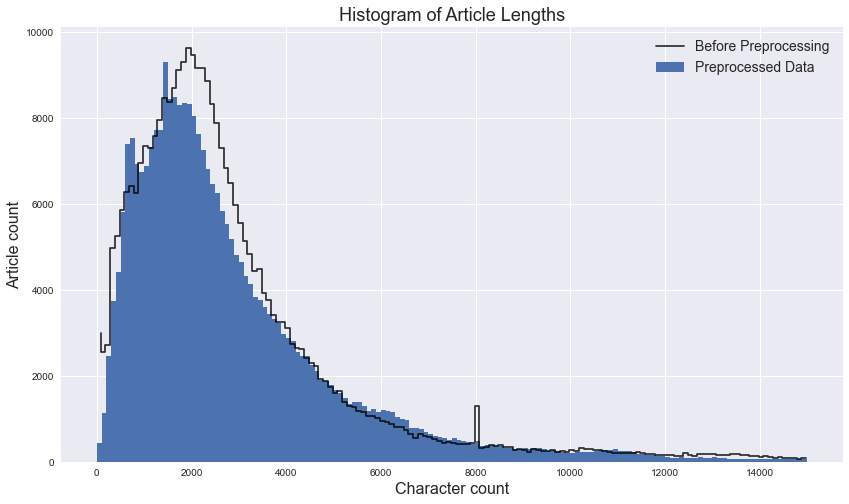

In [34]:
body_lengths = data['Body'].str.len()

desc = "A dent in article counts at 250 characters\nNot true"

y, bin_edges = np.histogram(body_lengths, bins=150, range=(0,15000))
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges), label="Preprocessed Data")
plt.step(x2+30, y2*0.41, 'k', alpha=0.8, label="Before Preprocessing")
plt.title("Histogram of Article Lengths", fontsize=18)
plt.xlabel("Character count", fontsize=16)
plt.ylabel("Article count", fontsize=16)
plt.legend(fontsize=14);
#plt.text(0.7, 0.7, desc, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=16)
#plt.plot([250,10000], [30,240], '--', c='red', alpha=.6)
#Ændr, så det passer med den endelige data.

### Author contributions
How many articles have the authors written?

In [ ]:
counts = list(data['Byline'].value_counts())

# plt.yscale('symlog')
# plt.xlim(-100,4000)

y, bin_edges = np.histogram(counts, bins=200)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges))

plt.yscale('symlog')
plt.title("Histogram Over Number of Articles per Author", fontsize=18)
plt.xlabel("Number of articles", fontsize=16)
plt.ylabel("Number of authors", fontsize=16)

desc = "Outlier: Mads Elkær\n53835 articles written."
plt.text(0.7, 0.7, desc, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=16)
plt.plot([40000,53000], [120,1], '--', c='red', alpha=.6)

### Author body length
Do authors have certain body lengths? In articles, not their actual bodies. Let us make a plot to see if there is a correlation between article count and body length. But first, we need to find the average body length per author. 

In [ ]:
df = pd.DataFrame(columns=['body_length', 'author'])
df['body_length'] = body_lengths
df['author'] = data['Byline']
df['author'].replace('', np.nan, inplace=True)
df = df.dropna()
avg_body_lengths = list(df.groupby(['author']).mean()['body_length'])

In [ ]:
plt.hist(avg_body_lengths, bins=200);
plt.title("Histogram Over Average Article Length per Author", fontsize=16)
plt.xlabel("Average length", fontsize=14)
plt.ylabel("Number of authors", fontsize=14)

In [ ]:
df2 = pd.DataFrame(index=data['Byline'].unique(),columns=['avg_len', 'article_count'])
avg_body_length_series = df.groupby(['author']).mean()['body_length']
article_count_series = data['Byline'].value_counts()

for i in data['Byline'].unique():
    if i == '':
        continue
    
    avg_len = avg_body_length_series[i]
    article_count = article_count_series[i]
    df2.loc[i] = [avg_len, article_count]

df2.head(5)

**Correlation between average length and article count**

Make a dataframe with author, average article length, article count

In [ ]:
x = df2.avg_len
y = df2.article_count
plt.scatter(x[y<2000], y[y<2000], marker='.')
plt.ylabel("Article count")
plt.xlabel("Article length")

x = x.to_numpy(dtype=float)
y = y.to_numpy(dtype=float)
x = np.nan_to_num(x)
y = np.nan_to_num(y)

corr, sig = pearsonr(x,y)
print("Pearsin correlation:", corr)

plt.title("No Linear Correlation Between Article Length and Article Count", fontsize=15);

In [ ]:
data.Byline.str.len().median()

# TESTING

In [ ]:
#Load all data into one big dataframe. Oh yes, it is possible!
files = os.listdir('data/additional/scraped')
files = [x for x in files if x[-4:]=='json'] #only take .json files.

data = pd.read_json('data/additional/scraped/'+files[0])
for file in tqdm(files[1:]):
    data = pd.concat([data, pd.read_json('data/additional/scraped/'+file)])

print_stats()

In [ ]:
import scraper
b, h = scraper.get_content("https://www.berlingske.dk/virksomheder/stor-cloud-tjeneste-dropper-flash")

In [ ]:

len(bodies)

In [ ]:
for 

In [ ]:
bodies[0]